# Notebook 08: The Easterlin Paradox

Notebook 07 established a striking cross-sectional finding: absolute income
(log GDP per capita) is the dominant predictor of national happiness, with a
partial correlation of r = 0.796 after controlling for inequality. The Gini
coefficient's apparent effect on happiness largely vanished once income was
accounted for.

This raises a natural follow-up question: **if absolute income is what matters,
then countries that have gotten substantially richer over time should also have
gotten substantially happier. Have they?**

This is the **Easterlin Paradox** (Easterlin 1974) — one of the most debated
findings in the economics of well-being. The paradox has three parts:

1. **Within** a country at a given time, richer people are happier (undisputed).
2. **Across** countries at a given time, richer countries are happier (Notebook 07 confirmed this).
3. **Over time**, as countries get richer, average happiness does not clearly rise.

If part 3 holds, it contradicts what parts 1 and 2 would predict.

### Key literature

- **Easterlin (1974)**: The founding paper. US income rose dramatically
  1946–1970, but average happiness was flat.
- **Stevenson & Wolfers (2008)**: Challenged the paradox using broader data.
  Argued that economic growth *is* associated with rising happiness.
- **Easterlin & O'Connor (2020)**: Rebutted. Distinguished short-run
  fluctuations (business cycles) from long-run trends. Argued the paradox
  holds for sustained growth over 10+ years.
- **Clark (2018)**: Hedonic adaptation and rising aspirations as mechanisms.
  People adjust to higher income; the "hedonic treadmill."
- **Bond & Lang (2025)**: Ordinal happiness scales may not be capable of
  detecting trends even if they exist.

We test this using three data sources of increasing time depth:

| Source | Period | Countries | Scale |
|--------|--------|-----------|-------|
| Gallup World Poll (via OWID) | ~2005–2024 | 130+ | Cantril Ladder 0–10 |
| US General Social Survey | 1972–present | 1 (USA) | 3-category |
| World Values Survey / EVS | 1981–2022 | ~100 | Life satisfaction 1–10 |

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from data.config import (
    FOCUS_COUNTRIES, WELLBEING_COUNTRIES, COUNTRY_NAMES, COUNTRY_COLORS,
    ISO2_TO_ISO3,
)
from data.plotting import (
    set_style, country_color, country_name, save_figure, annotate_countries,
)
from data import health_social

set_style()

# Income tier classification (from Notebook 07)
INCOME_TIERS = {
    'High income': ['US', 'GB', 'FR', 'DE', 'SE', 'DK', 'NO', 'JP', 'AU', 'CL'],
    'Upper-middle': ['CN', 'BR', 'MX', 'ZA', 'TR', 'RU'],
    'Lower-middle': ['IN', 'ID', 'PH', 'EG', 'NG'],
    'Low income': ['ET', 'BD'],
}
TIER_COLORS = {
    'High income': '#4878a8',
    'Upper-middle': '#4a9a73',
    'Lower-middle': '#c06820',
    'Low income': '#b5403a',
}
COUNTRY_TIER = {}
for tier, codes in INCOME_TIERS.items():
    for c in codes:
        COUNTRY_TIER[c] = tier

def tier_color(code):
    return TIER_COLORS.get(COUNTRY_TIER.get(code, ''), '#999999')

***
## 1. The Cross-Sectional Prediction

Before looking at trends over time, let's establish the cross-sectional
benchmark. Notebook 07 found a strong log-linear relationship between
GDP per capita and happiness across countries. If this gradient held
*within* countries over time, we can compute a prediction: how much
happier should a country become when its income doubles?

Cross-sectional gradient: 1.067 happiness points per unit of log GDP
Predicted happiness gain from doubling GDP: 0.74 points (on 0-10 scale)

US real GDP/capita roughly doubled from 1972 to 2020.
Cross-sectional prediction: US happiness should have risen by ~0.7 points.


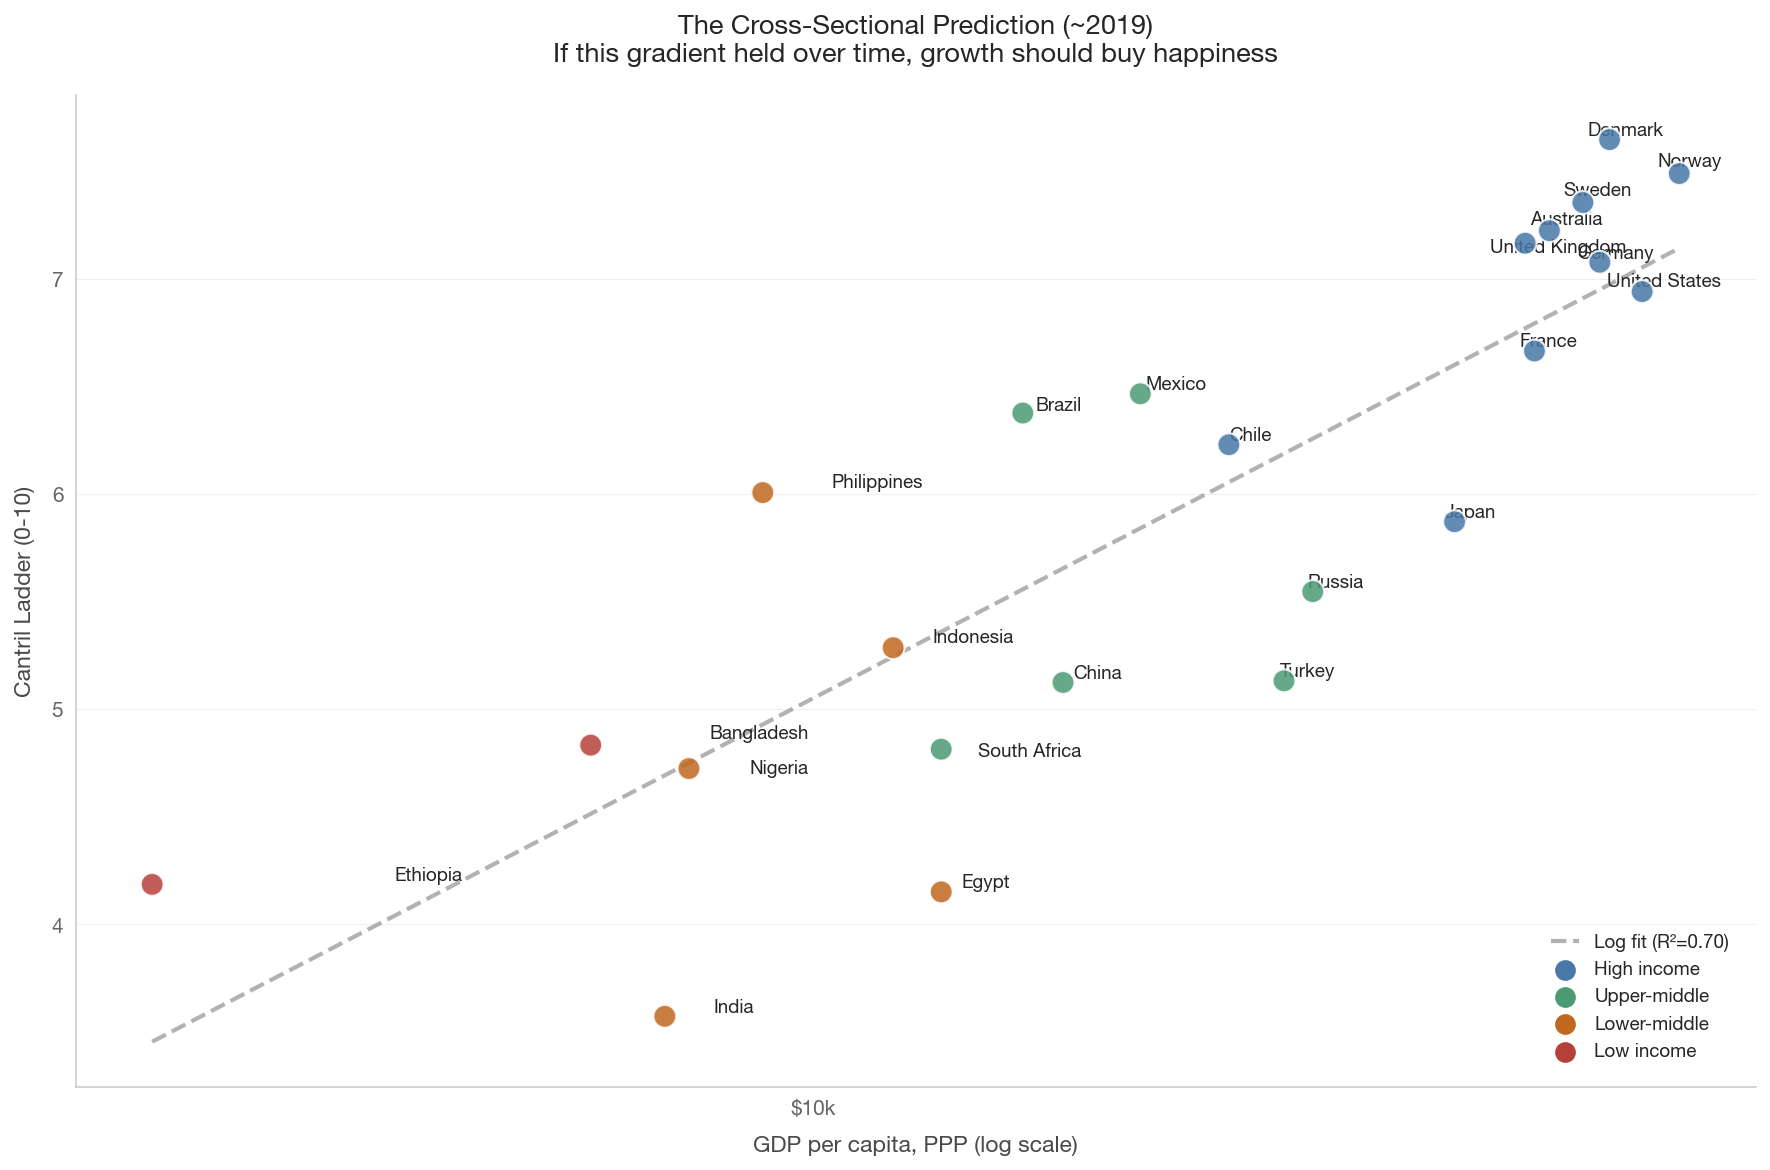

In [2]:
# Load cross-sectional data (same as Notebook 07)
wb_data = health_social.get_wellbeing_data(year=2019)
happiness = health_social.get_happiness_scores(year=2019)

if not happiness.empty and not wb_data.empty:
    wb_happy = wb_data.merge(happiness, on='country_code', how='inner')
    df = wb_happy.dropna(subset=['gdp_per_capita_ppp', 'happiness_score'])

    fig, ax = plt.subplots(figsize=(12, 8))

    colors = [tier_color(c) for c in df['country_code']]
    ax.scatter(df['gdp_per_capita_ppp'], df['happiness_score'],
               c=colors, s=120, zorder=5, edgecolors='white', linewidth=1,
               alpha=0.85)

    # Log fit
    x = np.log(df['gdp_per_capita_ppp'].values)
    y = df['happiness_score'].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 3:
        slope, intercept, r, p, se = stats.linregress(x[mask], y[mask])
        x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
        ax.plot(np.exp(x_fit), intercept + slope * x_fit,
                color='gray', linestyle='--', linewidth=2, alpha=0.6,
                label=f'Log fit (R\u00b2={r**2:.2f})')

        # Prediction: happiness gain from doubling income
        predicted_gain = slope * np.log(2)
        print(f"Cross-sectional gradient: {slope:.3f} happiness points "
              f"per unit of log GDP")
        print(f"Predicted happiness gain from doubling GDP: "
              f"{predicted_gain:.2f} points (on 0-10 scale)")
        print(f"\nUS real GDP/capita roughly doubled from 1972 to 2020.")
        print(f"Cross-sectional prediction: US happiness should have risen "
              f"by ~{predicted_gain:.1f} points.")

    annotate_countries(ax, df['gdp_per_capita_ppp'].values,
                       df['happiness_score'].values,
                       df['country_code'].values)

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(
        lambda x, _: f'${x/1000:.0f}k'))
    ax.set_xlabel('GDP per capita, PPP (log scale)')
    ax.set_ylabel('Cantril Ladder (0-10)')
    ax.set_title('The Cross-Sectional Prediction (~2019)\n'
                 'If this gradient held over time, growth should buy happiness',
                 fontsize=13)

    for tier, color in TIER_COLORS.items():
        ax.scatter([], [], c=color, s=80, label=tier)
    ax.legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    save_figure(fig, '08_cross_section_baseline')
    plt.show()
else:
    print('Cross-sectional data not available.')

***
## 2. The US Case: The Original Easterlin Evidence

The US is the canonical test case for the paradox. Real GDP per capita
has roughly tripled since 1972, yet the General Social Survey's happiness
question shows essentially no upward trend — and a notable decline since
the mid-2010s.

The GSS has asked the same question since 1972: *"Taken all together,
how would you say things are these days — would you say that you are
very happy, pretty happy, or not too happy?"*

### Data note
GSS data must be downloaded manually. If the file is not present at
`raw_data/gss_happiness.csv`, this section will be skipped. See
[GSS Data Explorer](https://gssdataexplorer.norc.org/) for download
instructions.

In [3]:
# Load GSS data
try:
    from data import gss
    gss_trend = gss.get_gss_happiness_trend()
    print(f"GSS data loaded: {len(gss_trend)} survey years, "
          f"{gss_trend['year'].min()}-{gss_trend['year'].max()}")
    display(gss_trend.head())
    gss_available = True
except FileNotFoundError as e:
    print(f"GSS data not available: {e}")
    print("\nSection 2 will be skipped. See download instructions above.")
    gss_available = False

GSS data loaded: 35 survey years, 1972-2024


,year,pct_very_happy,pct_pretty_happy,pct_not_happy,mean_happy,n_respondents
0,1972,29.723086,53.047052,17.229862,2.124932,1606
1,1973,36.795759,50.928974,12.275268,2.245205,1500
2,1974,38.307851,49.185439,12.506710,2.258011,1480
3,1975,33.406633,53.626369,12.966998,2.204396,1485
4,1976,34.845348,52.914292,12.240360,2.226050,1499


Pearson r (GDP vs % very happy): -0.738, p = 0.0003
Trend: -0.306 pct points/year, p = 0.0003


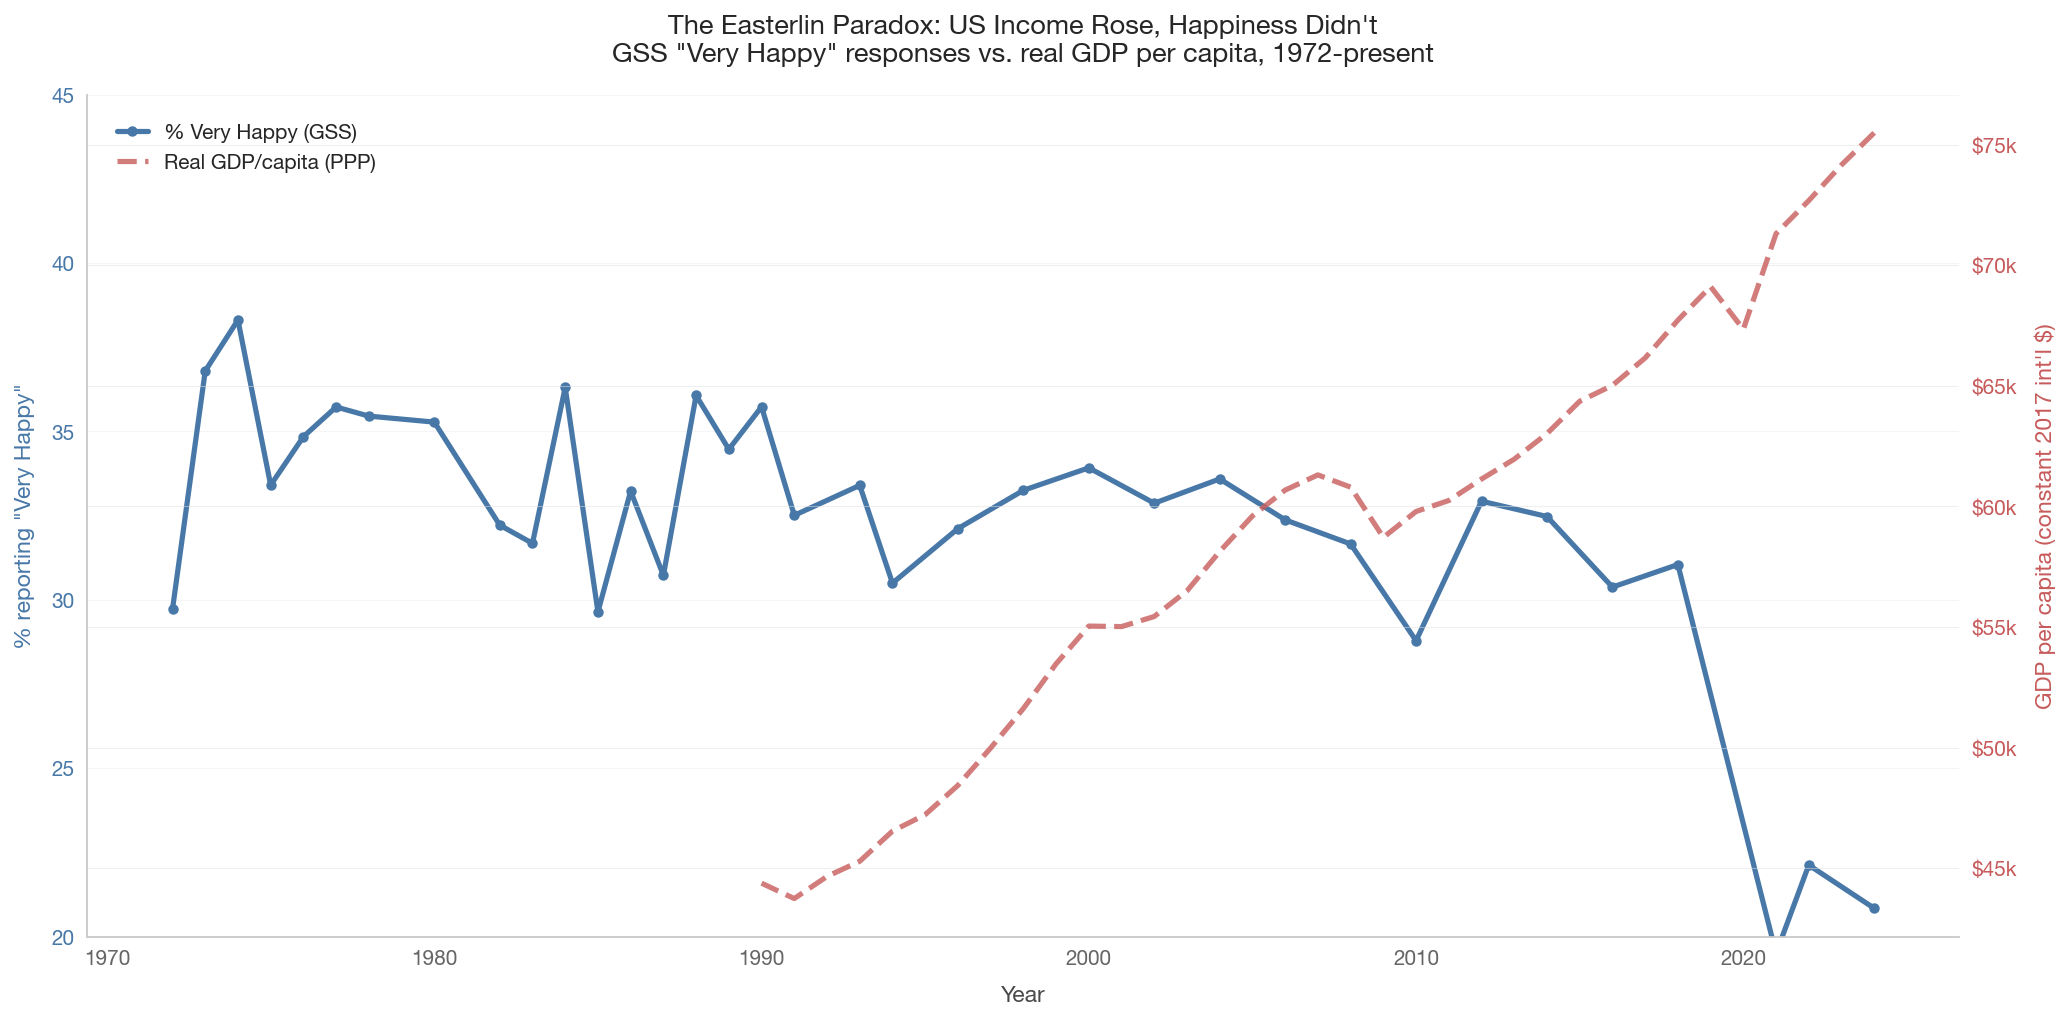

In [4]:
if gss_available:
    # Get US GDP time series
    us_gdp = health_social.get_gdp_timeseries(
        countries=['US'], start_year=1970, end_year=2024)

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Left axis: % very happy
    color_happy = '#4878a8'
    ax1.plot(gss_trend['year'], gss_trend['pct_very_happy'],
             color=color_happy, linewidth=2.5, marker='o', markersize=4,
             label='% Very Happy (GSS)', zorder=5)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('% reporting "Very Happy"', color=color_happy)
    ax1.tick_params(axis='y', labelcolor=color_happy)
    ax1.set_ylim(20, 45)

    # Right axis: GDP per capita
    if not us_gdp.empty:
        ax2 = ax1.twinx()
        color_gdp = '#c75b5b'
        ax2.plot(us_gdp['year'], us_gdp['gdp_per_capita_ppp'],
                 color=color_gdp, linewidth=2.5, linestyle='--',
                 label='Real GDP/capita (PPP)', alpha=0.8)
        ax2.set_ylabel('GDP per capita (constant 2017 int\'l $)',
                       color=color_gdp)
        ax2.tick_params(axis='y', labelcolor=color_gdp)
        ax2.yaxis.set_major_formatter(mtick.FuncFormatter(
            lambda x, _: f'${x/1000:.0f}k'))

        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2,
                   loc='upper left', fontsize=10)
    else:
        ax1.legend(loc='upper left', fontsize=10)

    ax1.set_title('The Easterlin Paradox: US Income Rose, Happiness Didn\'t\n'
                  'GSS "Very Happy" responses vs. real GDP per capita, 1972-present',
                  fontsize=13)
    ax1.grid(axis='y', alpha=0.3)

    # Compute and report correlation
    if not us_gdp.empty:
        merged = gss_trend.merge(us_gdp, on='year', how='inner')
        if len(merged) > 5:
            r, p = stats.pearsonr(merged['gdp_per_capita_ppp'],
                                  merged['pct_very_happy'])
            print(f"Pearson r (GDP vs % very happy): {r:.3f}, p = {p:.4f}")
            sl, it, r_t, p_t, _ = stats.linregress(
                merged['year'], merged['pct_very_happy'])
            print(f"Trend: {sl:.3f} pct points/year, p = {p_t:.4f}")

    plt.tight_layout()
    save_figure(fig, '08_us_gss_dual_axis')
    plt.show()
else:
    print('GSS data not available for dual-axis plot.')

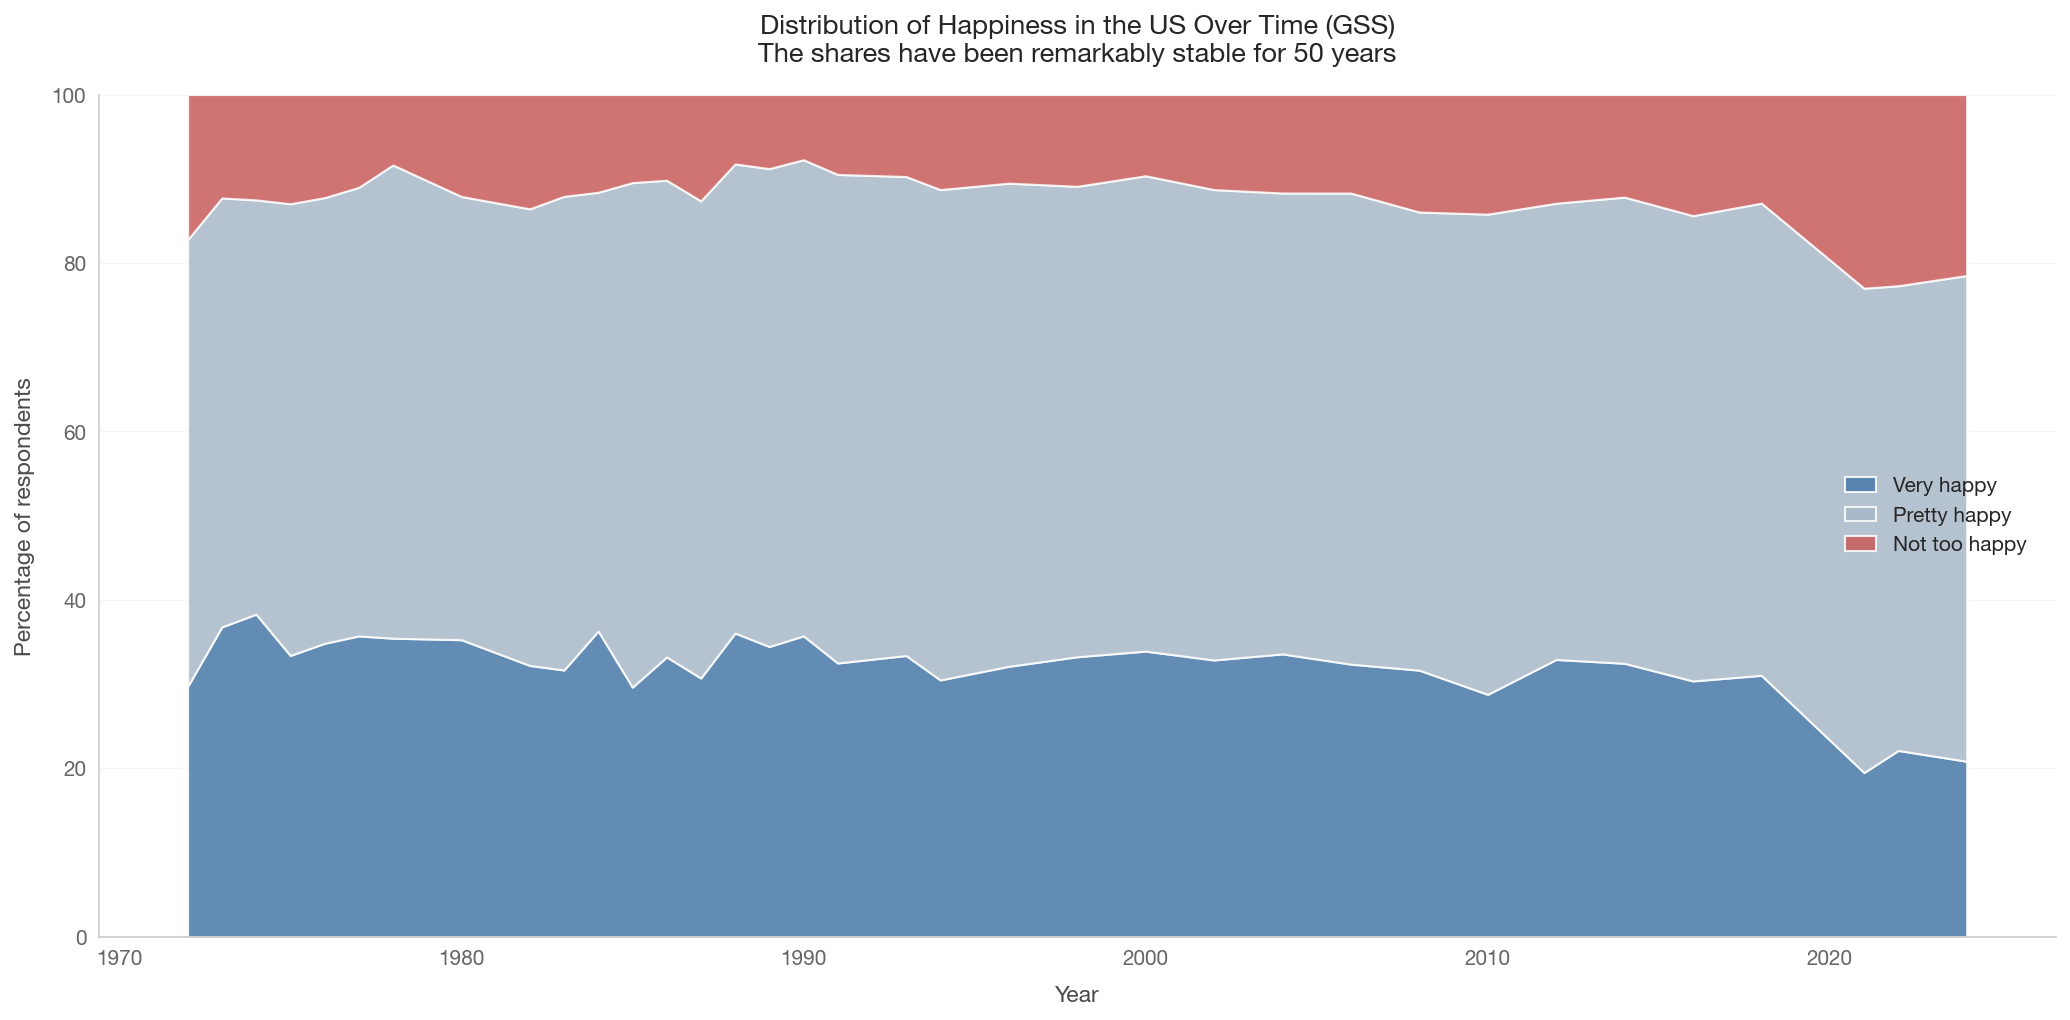

In [5]:
if gss_available:
    fig, ax = plt.subplots(figsize=(14, 7))

    years = gss_trend['year'].values
    very = gss_trend['pct_very_happy'].values
    pretty = gss_trend['pct_pretty_happy'].values
    not_happy = gss_trend['pct_not_happy'].values

    ax.stackplot(years, very, pretty, not_happy,
                 labels=['Very happy', 'Pretty happy', 'Not too happy'],
                 colors=['#4878a8', '#a8b8c8', '#c75b5b'],
                 alpha=0.85)

    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of respondents')
    ax.set_title('Distribution of Happiness in the US Over Time (GSS)\n'
                 'The shares have been remarkably stable for 50 years',
                 fontsize=13)
    ax.set_ylim(0, 100)
    ax.legend(loc='center right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '08_us_gss_distribution')
    plt.show()
else:
    print('GSS data not available for distribution plot.')

***
## 3. The Global Panel: Cantril Ladder 2005–2024

The Gallup World Poll has surveyed happiness in 130+ countries since
~2005. This gives us a shorter time window than the GSS, but far
broader country coverage. If the cross-sectional gradient holds over
time, we should see upward trends in most countries — especially
those that experienced rapid growth (China, India, Ethiopia).

In [6]:
# Load Cantril Ladder time series
happiness_ts = health_social.get_happiness_timeseries(
    start_year=2005, end_year=2024)

if not happiness_ts.empty:
    print(f"Cantril Ladder time series: {happiness_ts['country_code'].nunique()} "
          f"countries, {len(happiness_ts)} observations")
    print(f"Year range: {happiness_ts['year'].min()}-{happiness_ts['year'].max()}")
else:
    print('Cantril Ladder time series not available.')

Cantril Ladder time series: 40 countries, 520 observations
Year range: 2011-2024


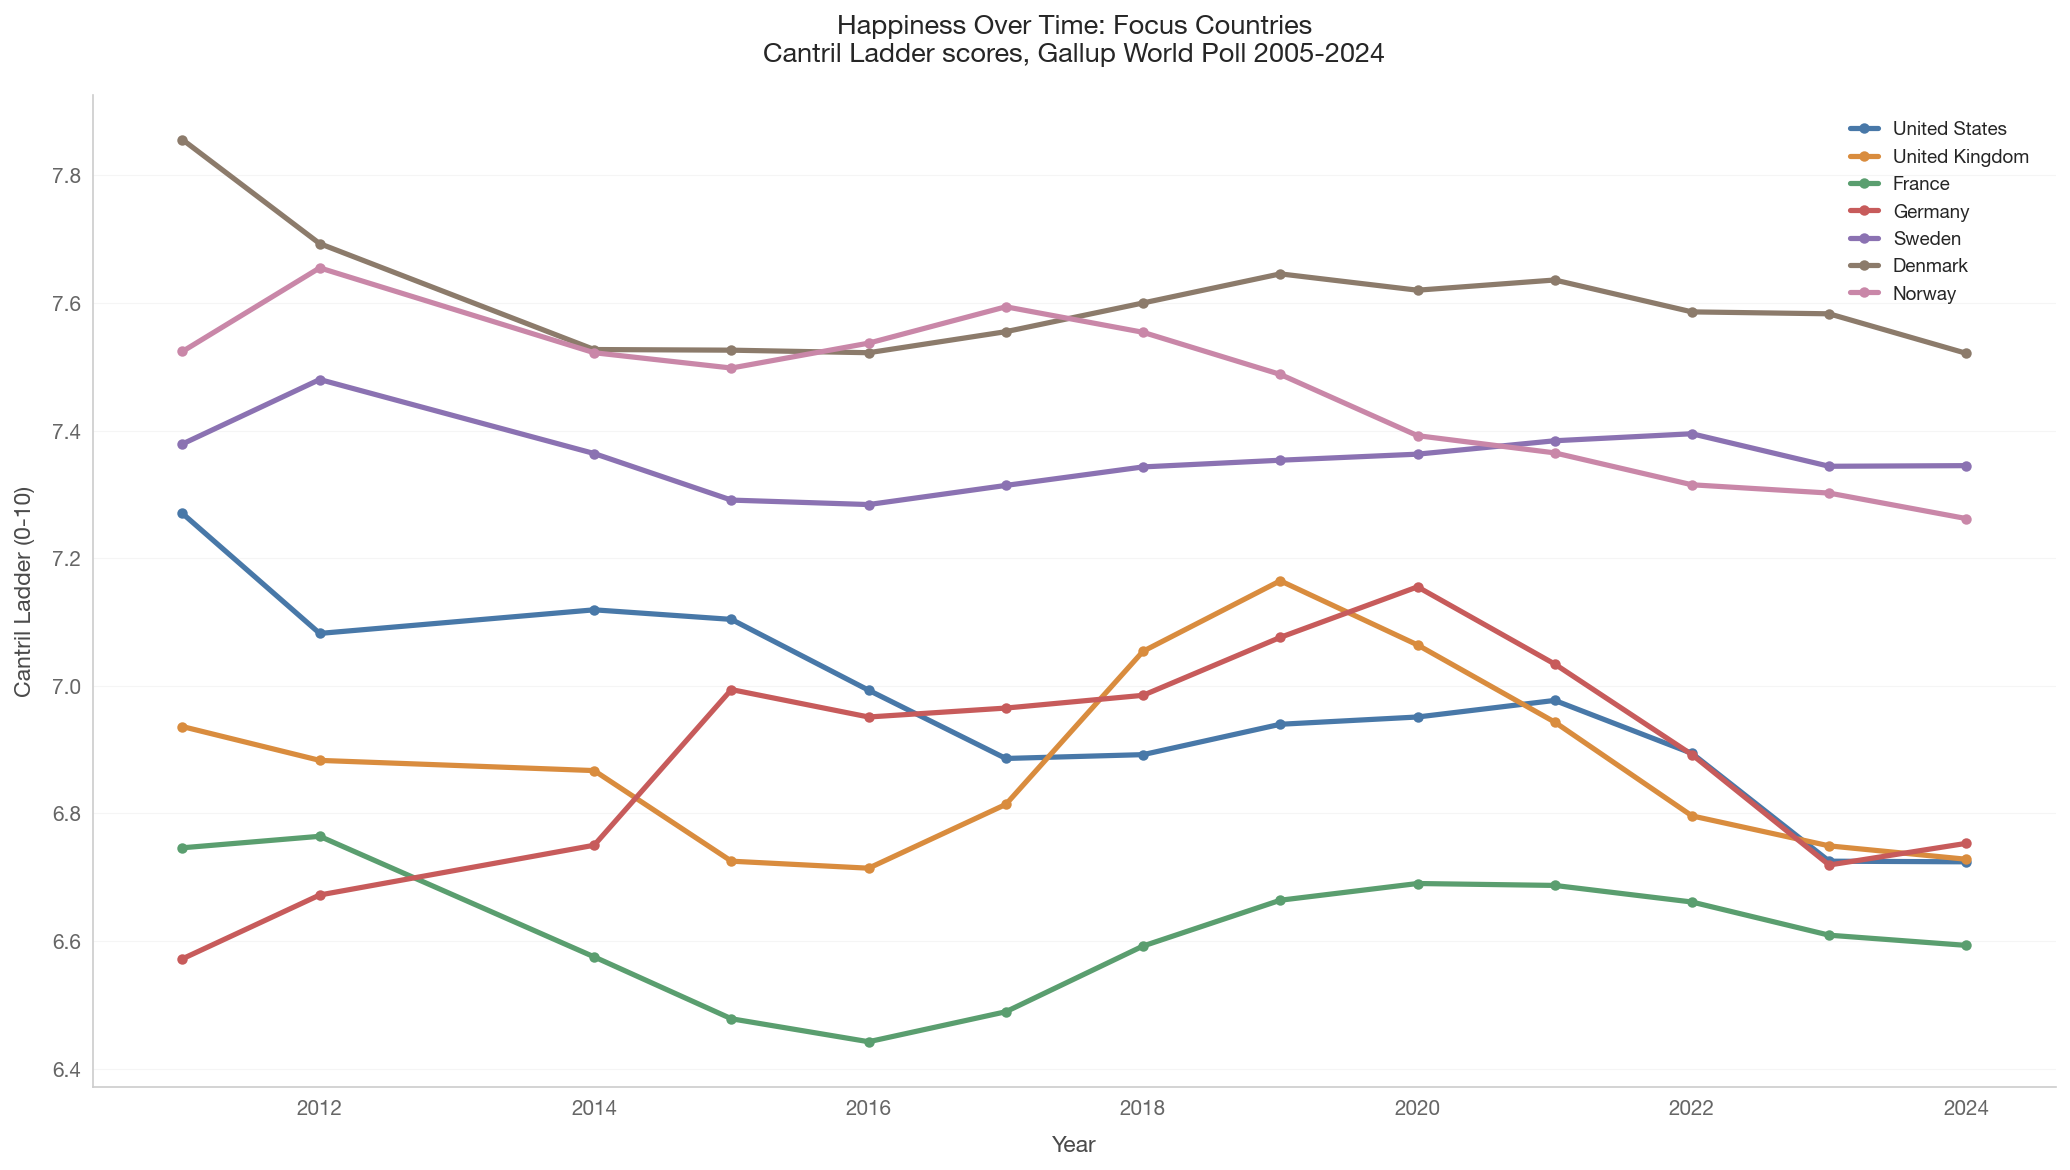

In [7]:
if not happiness_ts.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    for cc in FOCUS_COUNTRIES:
        cdf = happiness_ts[happiness_ts['country_code'] == cc].sort_values('year')
        if not cdf.empty:
            ax.plot(cdf['year'], cdf['happiness_score'],
                    color=country_color(cc), linewidth=2.5,
                    marker='o', markersize=4,
                    label=country_name(cc))

    ax.set_xlabel('Year')
    ax.set_ylabel('Cantril Ladder (0-10)')
    ax.set_title('Happiness Over Time: Focus Countries\n'
                 'Cantril Ladder scores, Gallup World Poll 2005-2024',
                 fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '08_cantril_timeseries_focus')
    plt.show()
else:
    print('Cantril data not available for focus countries plot.')

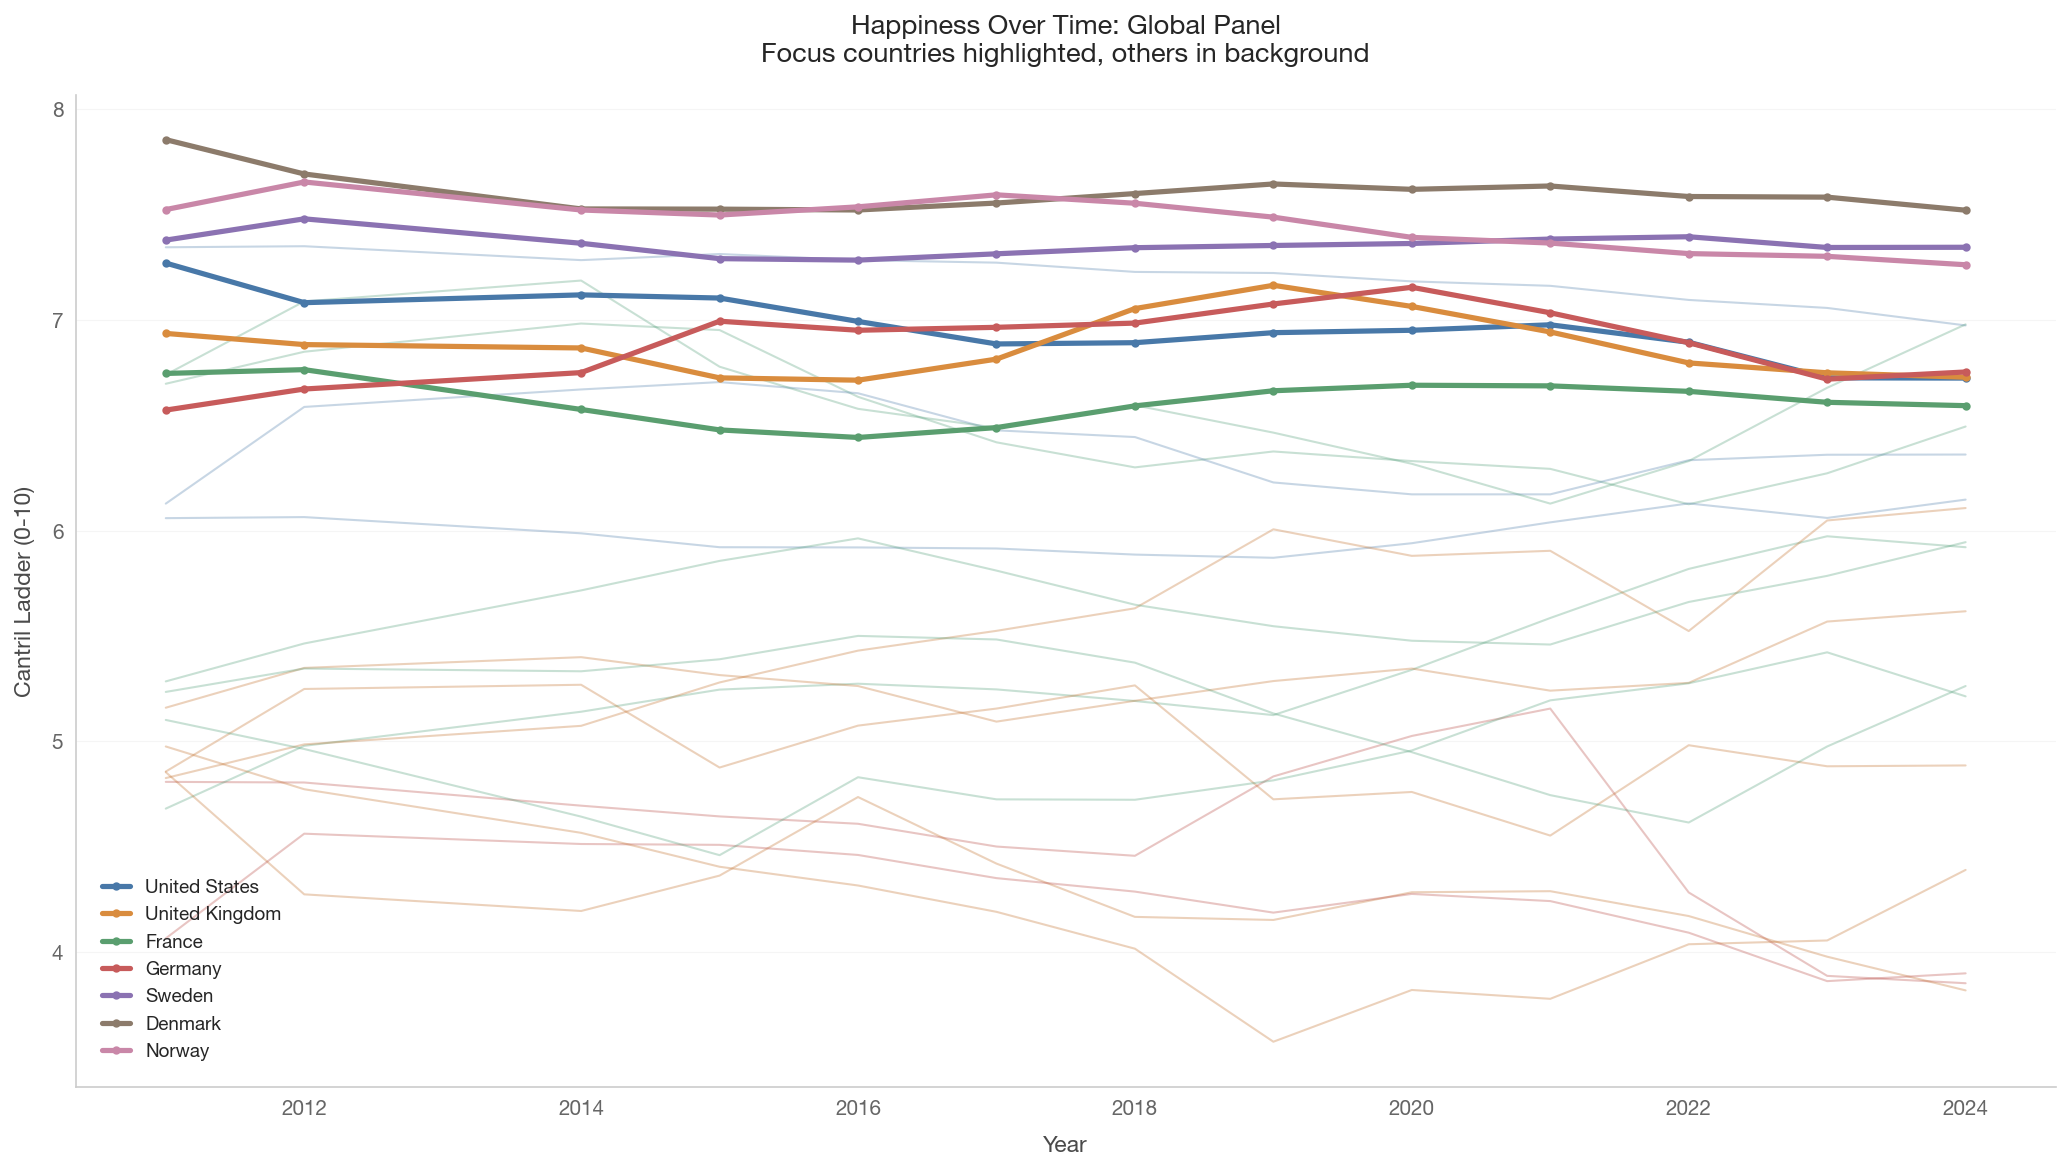


Per-country happiness trends (OLS):
Country               Years   Slope/yr    p-value  Total chg
------------------------------------------------------------
Australia                13    -0.0264     0.0000*     -0.343
Bangladesh               13    -0.0473     0.0817      -0.614
Brazil                   13    -0.0519     0.0022*     -0.675
Chile                    13    -0.0184     0.2018      -0.239
China                    13    +0.0836     0.0000*     +1.087
Germany                  13    +0.0149     0.2412      +0.193
Denmark                  13    -0.0099     0.1286      -0.129
Egypt                    13    -0.0474     0.0066*     -0.616
Ethiopia                 13    -0.0371     0.0119*     -0.482
France                   13    -0.0016     0.8296      -0.021
United Kingdom           13    -0.0027     0.8031      -0.035
Indonesia                13    +0.0176     0.0880      +0.229
India                    13    -0.0681     0.0076*     -0.886
Japan                    13    +0.0

In [8]:
if not happiness_ts.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    all_countries = happiness_ts['country_code'].unique()
    wb_set = set(WELLBEING_COUNTRIES)
    focus_set = set(FOCUS_COUNTRIES)

    # Background: all WELLBEING_COUNTRIES in light gray
    for cc in all_countries:
        if cc in wb_set and cc not in focus_set:
            cdf = happiness_ts[happiness_ts['country_code'] == cc].sort_values('year')
            if len(cdf) >= 3:
                ax.plot(cdf['year'], cdf['happiness_score'],
                        color=tier_color(cc), linewidth=1, alpha=0.3)

    # Foreground: focus countries
    for cc in FOCUS_COUNTRIES:
        cdf = happiness_ts[happiness_ts['country_code'] == cc].sort_values('year')
        if not cdf.empty:
            ax.plot(cdf['year'], cdf['happiness_score'],
                    color=country_color(cc), linewidth=2.5,
                    marker='o', markersize=3,
                    label=country_name(cc))

    ax.set_xlabel('Year')
    ax.set_ylabel('Cantril Ladder (0-10)')
    ax.set_title('Happiness Over Time: Global Panel\n'
                 'Focus countries highlighted, others in background',
                 fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '08_cantril_timeseries_global')
    plt.show()

    # Per-country OLS trends
    total_chg_header = 'Total chg'
    print("\nPer-country happiness trends (OLS):")
    print(f"{'Country':<20} {'Years':>6} {'Slope/yr':>10} {'p-value':>10} "
          f"{total_chg_header:>10}")
    print("-" * 60)

    trend_rows = []
    for cc in sorted(happiness_ts['country_code'].unique()):
        cdf = happiness_ts[happiness_ts['country_code'] == cc].sort_values('year')
        if len(cdf) < 5:
            continue
        sl, it, r, p_val, se = stats.linregress(cdf['year'],
                                                 cdf['happiness_score'])
        n_years = cdf['year'].max() - cdf['year'].min()
        total_change = sl * n_years
        trend_rows.append({
            'country_code': cc, 'slope': sl, 'p_value': p_val,
            'total_change': total_change, 'n_years': n_years,
        })
        if cc in WELLBEING_COUNTRIES:
            sig = '*' if p_val < 0.05 else ' '
            print(f"{country_name(cc):<20} {n_years:>6} {sl:>+10.4f} "
                  f"{p_val:>10.4f}{sig} {total_change:>+10.3f}")

    trend_df = pd.DataFrame(trend_rows)
    print(f"\nCountries with significant positive trend: "
          f"{len(trend_df[(trend_df['slope'] > 0) & (trend_df['p_value'] < 0.05)])}")
    print(f"Countries with significant negative trend: "
          f"{len(trend_df[(trend_df['slope'] < 0) & (trend_df['p_value'] < 0.05)])}")
    print(f"Countries with no significant trend: "
          f"{len(trend_df[trend_df['p_value'] >= 0.05])}")
else:
    print('Cantril data not available for global panel.')

***
## 4. The Key Test: Growth vs. Happiness Change

This is the direct test of the paradox. For each country with sufficient
data, we compute:
- **Cumulative GDP growth** (log change in real GDP per capita)
- **Cumulative happiness change** (difference in Cantril Ladder score)

If the cross-sectional gradient held over time, we'd expect a strong
positive relationship. The Easterlin prediction is that the relationship
is weak or absent.

Countries with sufficient data: 40
Pearson r: 0.134 (p = 0.4111)
Spearman rho: 0.063 (p = 0.6996)


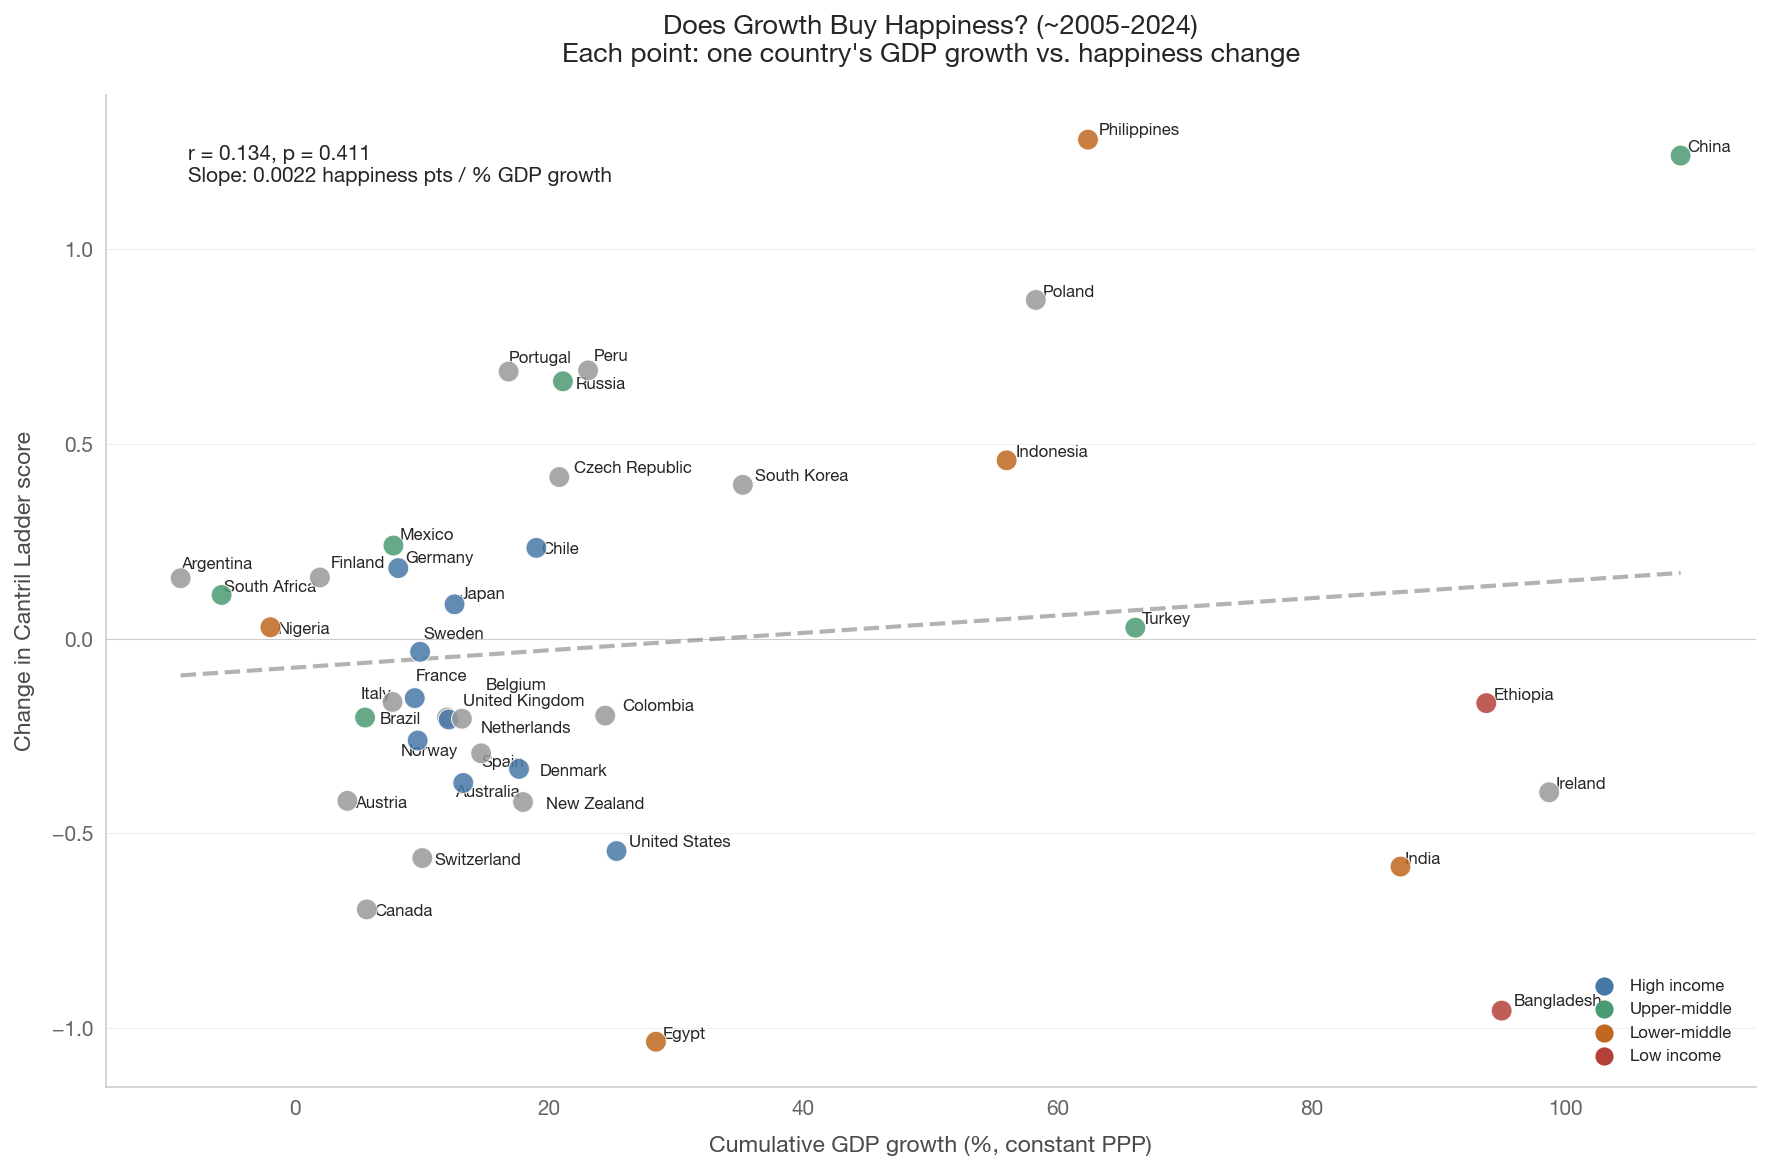

In [9]:
if not happiness_ts.empty:
    # Load GDP time series for all available countries
    happy_countries = happiness_ts['country_code'].unique().tolist()
    gdp_ts = health_social.get_gdp_timeseries(
        countries=happy_countries, start_year=2005, end_year=2024)

    if not gdp_ts.empty:
        # Merge happiness and GDP
        merged = happiness_ts.merge(gdp_ts, on=['country_code', 'year'])

        # Compute first/last deltas per country
        deltas = []
        for cc, group in merged.groupby('country_code'):
            group = group.sort_values('year').dropna()
            if len(group) < 5:
                continue
            first = group.iloc[0]
            last = group.iloc[-1]
            if first['gdp_per_capita_ppp'] <= 0:
                continue
            deltas.append({
                'country_code': cc,
                'year_start': int(first['year']),
                'year_end': int(last['year']),
                'delta_happiness': (last['happiness_score']
                                    - first['happiness_score']),
                'delta_log_gdp': (np.log(last['gdp_per_capita_ppp'])
                                  - np.log(first['gdp_per_capita_ppp'])),
                'pct_gdp_growth': ((last['gdp_per_capita_ppp']
                                    / first['gdp_per_capita_ppp'] - 1) * 100),
            })

        delta_df = pd.DataFrame(deltas)
        print(f"Countries with sufficient data: {len(delta_df)}")

        if len(delta_df) >= 5:
            fig, ax = plt.subplots(figsize=(12, 8))

            colors = [tier_color(c) for c in delta_df['country_code']]
            ax.scatter(delta_df['pct_gdp_growth'],
                       delta_df['delta_happiness'],
                       c=colors, s=100, zorder=5, edgecolors='white',
                       linewidth=0.5, alpha=0.85)

            # Regression line
            x = delta_df['pct_gdp_growth'].values
            y = delta_df['delta_happiness'].values
            mask = np.isfinite(x) & np.isfinite(y)
            if mask.sum() > 3:
                sl, it, r, p, se = stats.linregress(x[mask], y[mask])
                x_fit = np.linspace(x[mask].min(), x[mask].max(), 100)
                ax.plot(x_fit, it + sl * x_fit, color='gray',
                        linestyle='--', linewidth=2, alpha=0.6)
                ax.text(0.05, 0.95,
                        f'r = {r:.3f}, p = {p:.3f}\n'
                        f'Slope: {sl:.4f} happiness pts / % GDP growth',
                        transform=ax.transAxes, fontsize=10, va='top',
                        bbox=dict(boxstyle='round', facecolor='white',
                                  alpha=0.8))

                # Spearman rank correlation
                rho, p_rho = stats.spearmanr(x[mask], y[mask])
                print(f"Pearson r: {r:.3f} (p = {p:.4f})")
                print(f"Spearman rho: {rho:.3f} (p = {p_rho:.4f})")

            annotate_countries(
                ax, delta_df['pct_gdp_growth'].values,
                delta_df['delta_happiness'].values,
                delta_df['country_code'].values, fontsize=8)

            ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
            ax.set_xlabel('Cumulative GDP growth (%, constant PPP)')
            ax.set_ylabel('Change in Cantril Ladder score')
            ax.set_title('Does Growth Buy Happiness? (~2005-2024)\n'
                         'Each point: one country\'s GDP growth vs. '
                         'happiness change',
                         fontsize=13)

            for tier, color in TIER_COLORS.items():
                ax.scatter([], [], c=color, s=60, label=tier)
            ax.legend(loc='lower right', fontsize=8)

            plt.tight_layout()
            save_figure(fig, '08_growth_vs_happiness_change')
            plt.show()
    else:
        print('GDP time series not available.')
else:
    print('Cantril data not available for growth-happiness analysis.')

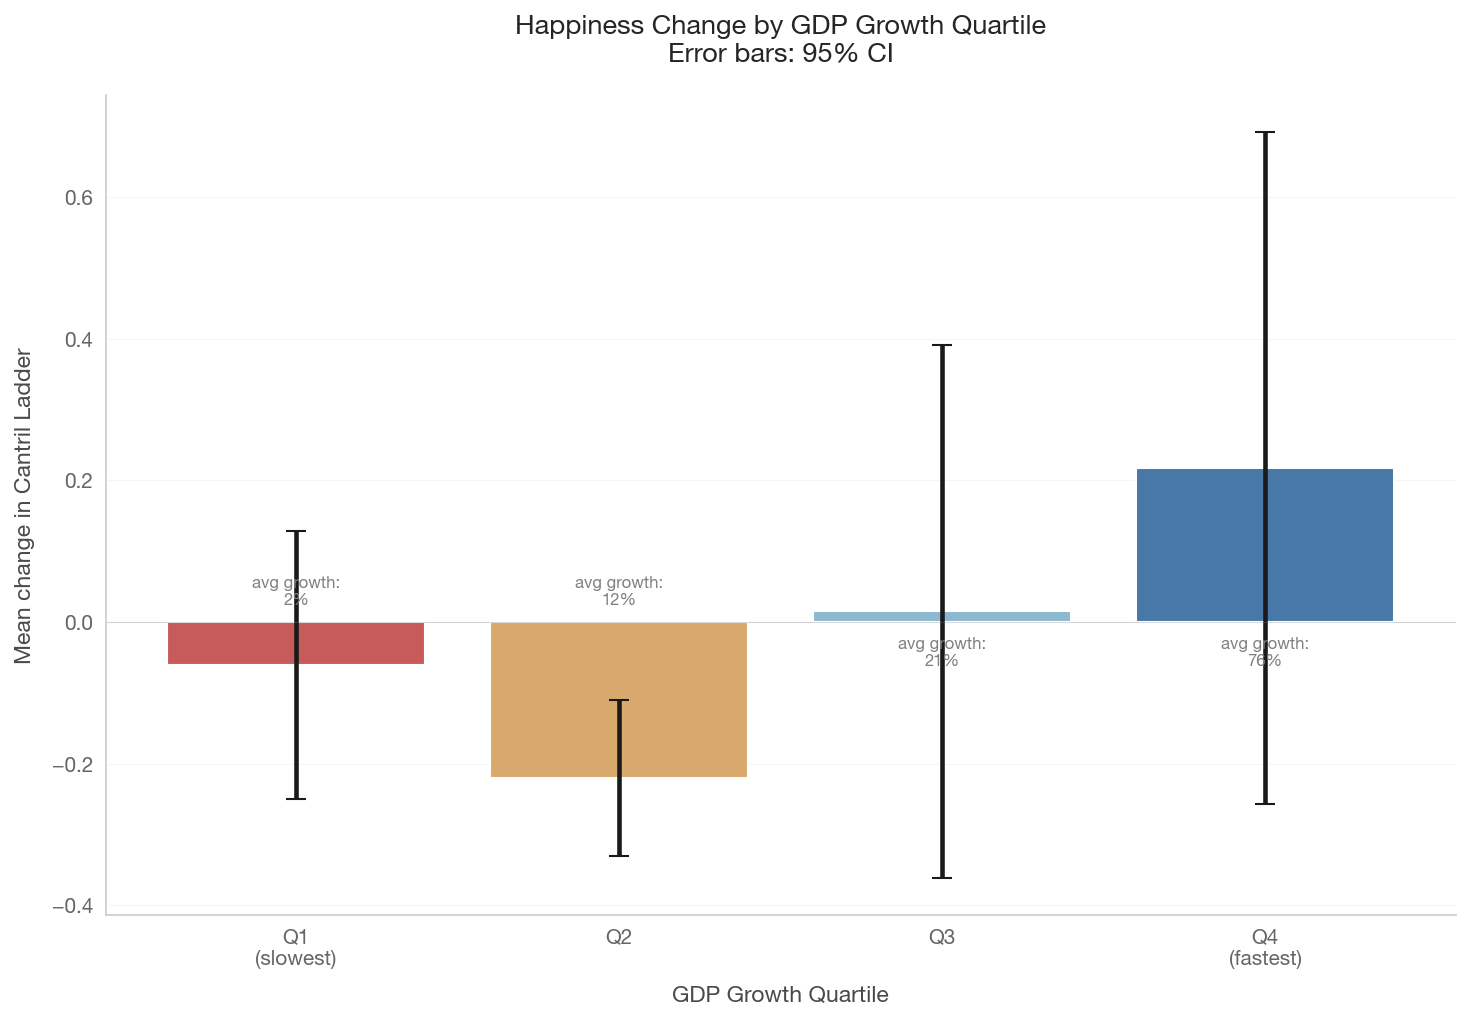

In [10]:
if not happiness_ts.empty and 'delta_df' in dir() and len(delta_df) >= 8:
    fig, ax = plt.subplots(figsize=(10, 7))

    # Group into GDP-growth quartiles
    delta_df['growth_quartile'] = pd.qcut(
        delta_df['pct_gdp_growth'], q=4,
        labels=['Q1\n(slowest)', 'Q2', 'Q3', 'Q4\n(fastest)'])

    quartile_stats = (delta_df.groupby('growth_quartile',
                                        observed=True)
                      .agg(
                          mean_change=('delta_happiness', 'mean'),
                          se_change=('delta_happiness',
                                     lambda x: x.std() / np.sqrt(len(x))),
                          n=('delta_happiness', 'count'),
                          mean_growth=('pct_gdp_growth', 'mean'),
                      ).reset_index())

    bars = ax.bar(range(len(quartile_stats)),
                  quartile_stats['mean_change'],
                  yerr=quartile_stats['se_change'] * 1.96,
                  color=['#c75b5b', '#d9a86c', '#8cb8d0', '#4878a8'],
                  capsize=5, edgecolor='white', linewidth=1)

    ax.set_xticks(range(len(quartile_stats)))
    ax.set_xticklabels(quartile_stats['growth_quartile'])
    ax.set_xlabel('GDP Growth Quartile')
    ax.set_ylabel('Mean change in Cantril Ladder')
    ax.set_title('Happiness Change by GDP Growth Quartile\n'
                 'Error bars: 95% CI',
                 fontsize=13)
    ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

    # Annotate with mean growth rate
    for i, row in quartile_stats.iterrows():
        ax.text(i, -0.02 if row['mean_change'] >= 0 else 0.02,
                f"avg growth:\n{row['mean_growth']:.0f}%",
                ha='center', va='top' if row['mean_change'] >= 0 else 'bottom',
                fontsize=8, color='gray')

    plt.tight_layout()
    save_figure(fig, '08_growth_vs_happiness_binned')
    plt.show()
else:
    print('Insufficient data for quartile analysis.')

***
## 5. Short-Run vs. Long-Run

Easterlin & O'Connor (2020) argue that Stevenson & Wolfers (2008)
conflated short-run and long-run effects. In the short run (business
cycles), GDP fluctuations *are* correlated with happiness changes —
recessions make people unhappy. But in the long run (10+ years of
sustained growth), the relationship vanishes.

We test this by comparing:
- **Short-run**: 5-year rolling windows of GDP growth vs. happiness change
- **Long-run**: Full-period (~15-19 year) changes

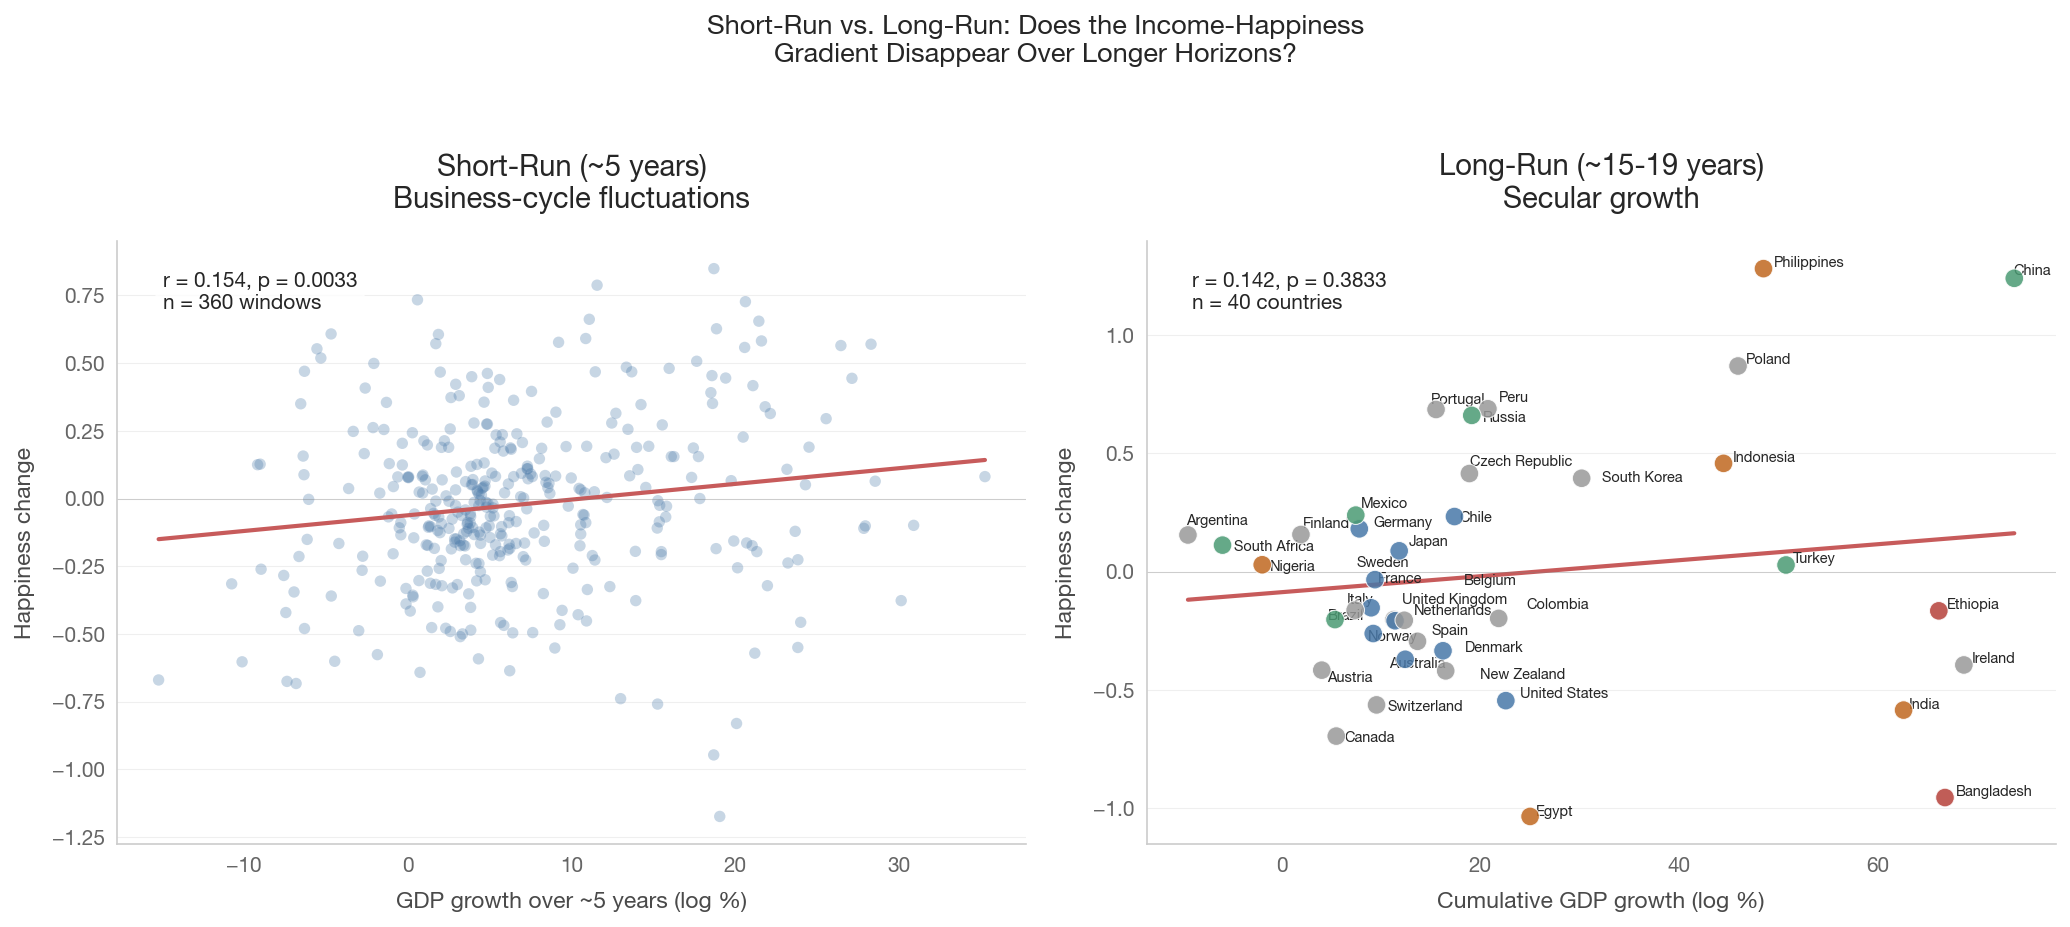


Short-run (5-year) gradient: pooled across 360 country-windows
Long-run (full-period) gradient: 40 countries


In [11]:
if not happiness_ts.empty and not gdp_ts.empty:
    merged_all = happiness_ts.merge(gdp_ts, on=['country_code', 'year'])

    # Short-run: 5-year rolling windows
    short_run = []
    for cc, group in merged_all.groupby('country_code'):
        group = group.sort_values('year').dropna()
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                yr_diff = group.iloc[j]['year'] - group.iloc[i]['year']
                if 4 <= yr_diff <= 6:  # approximately 5 years
                    gdp_i = group.iloc[i]['gdp_per_capita_ppp']
                    gdp_j = group.iloc[j]['gdp_per_capita_ppp']
                    if gdp_i > 0:
                        short_run.append({
                            'country_code': cc,
                            'delta_log_gdp': np.log(gdp_j) - np.log(gdp_i),
                            'delta_happiness': (group.iloc[j]['happiness_score']
                                                - group.iloc[i]['happiness_score']),
                            'yr_diff': yr_diff,
                        })
                    break  # only closest ~5yr window per start year

    short_df = pd.DataFrame(short_run)

    if len(short_df) >= 10 and 'delta_df' in dir() and len(delta_df) >= 5:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Panel 1: Short-run (5-year windows)
        ax = axes[0]
        ax.scatter(short_df['delta_log_gdp'] * 100,
                   short_df['delta_happiness'],
                   alpha=0.3, s=30, color='#4878a8', edgecolors='none')
        x_s = (short_df['delta_log_gdp'] * 100).values
        y_s = short_df['delta_happiness'].values
        m_s = np.isfinite(x_s) & np.isfinite(y_s)
        if m_s.sum() > 3:
            sl, it, r, p, _ = stats.linregress(x_s[m_s], y_s[m_s])
            xf = np.linspace(x_s[m_s].min(), x_s[m_s].max(), 100)
            ax.plot(xf, it + sl * xf, color='#c75b5b', linewidth=2)
            ax.text(0.05, 0.95, f'r = {r:.3f}, p = {p:.4f}\n'
                    f'n = {m_s.sum()} windows',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8))
        ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('GDP growth over ~5 years (log %)')
        ax.set_ylabel('Happiness change')
        ax.set_title('Short-Run (~5 years)\nBusiness-cycle fluctuations')

        # Panel 2: Long-run (full period)
        ax = axes[1]
        colors = [tier_color(c) for c in delta_df['country_code']]
        ax.scatter(delta_df['delta_log_gdp'] * 100,
                   delta_df['delta_happiness'],
                   c=colors, s=80, zorder=5, edgecolors='white',
                   linewidth=0.5, alpha=0.85)
        x_l = (delta_df['delta_log_gdp'] * 100).values
        y_l = delta_df['delta_happiness'].values
        m_l = np.isfinite(x_l) & np.isfinite(y_l)
        if m_l.sum() > 3:
            sl, it, r, p, _ = stats.linregress(x_l[m_l], y_l[m_l])
            xf = np.linspace(x_l[m_l].min(), x_l[m_l].max(), 100)
            ax.plot(xf, it + sl * xf, color='#c75b5b', linewidth=2)
            ax.text(0.05, 0.95, f'r = {r:.3f}, p = {p:.4f}\n'
                    f'n = {m_l.sum()} countries',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8))
        ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Cumulative GDP growth (log %)')
        ax.set_ylabel('Happiness change')
        ax.set_title('Long-Run (~15-19 years)\nSecular growth')

        annotate_countries(
            ax, (delta_df['delta_log_gdp'] * 100).values,
            delta_df['delta_happiness'].values,
            delta_df['country_code'].values, fontsize=7)

        fig.suptitle('Short-Run vs. Long-Run: Does the Income-Happiness\n'
                     'Gradient Disappear Over Longer Horizons?',
                     fontsize=13, y=1.03)
        plt.tight_layout()
        save_figure(fig, '08_short_vs_long_run')
        plt.show()

        print(f"\nShort-run (5-year) gradient: pooled across "
              f"{len(short_df)} country-windows")
        print(f"Long-run (full-period) gradient: {len(delta_df)} countries")
    else:
        print('Insufficient data for short-run vs. long-run comparison.')
else:
    print('Data not available for short-run vs. long-run analysis.')

***
## 6. The Long View: World Values Survey 1981–2022

The Gallup data only goes back to ~2005. The World Values Survey,
combined with the European Values Study, provides life satisfaction
data from 1981 onward — covering the period of most dramatic global
GDP growth. If any dataset can resolve the paradox, it's this one.

Caveats:
- WVS surveys countries in **waves** (~every 5 years), not annually.
- Life satisfaction is on a 1–10 scale (not the 0–10 Cantril Ladder).
- Not every country appears in every wave.

### Data note
WVS data requires free registration at
[worldvaluessurvey.org](https://www.worldvaluessurvey.org/WVSDocumentation.jsp).
Download the WVS Time-Series (1981–2022) in CSV format and place it at
`raw_data/wvs_timeseries.csv`. This section will be skipped gracefully
if the file is not present.

In [12]:
try:
    from data import wvs
    wvs_trend = wvs.get_wvs_satisfaction_trend(min_waves=4)
    print(f"WVS data loaded: {wvs_trend['country_code'].nunique()} countries "
          f"with 4+ waves")
    print(f"Waves: {sorted(wvs_trend['wave'].unique())}")
    print(f"Year range: {wvs_trend['year_midpoint'].min()}-"
          f"{wvs_trend['year_midpoint'].max()}")
    wvs_available = True
except FileNotFoundError as e:
    print(f"WVS data not available: {e}")
    print("\nSection 6 will be skipped. See download instructions above.")
    wvs_available = False

WVS data loaded: 31 countries with 4+ waves
Waves: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Year range: 1981-2023


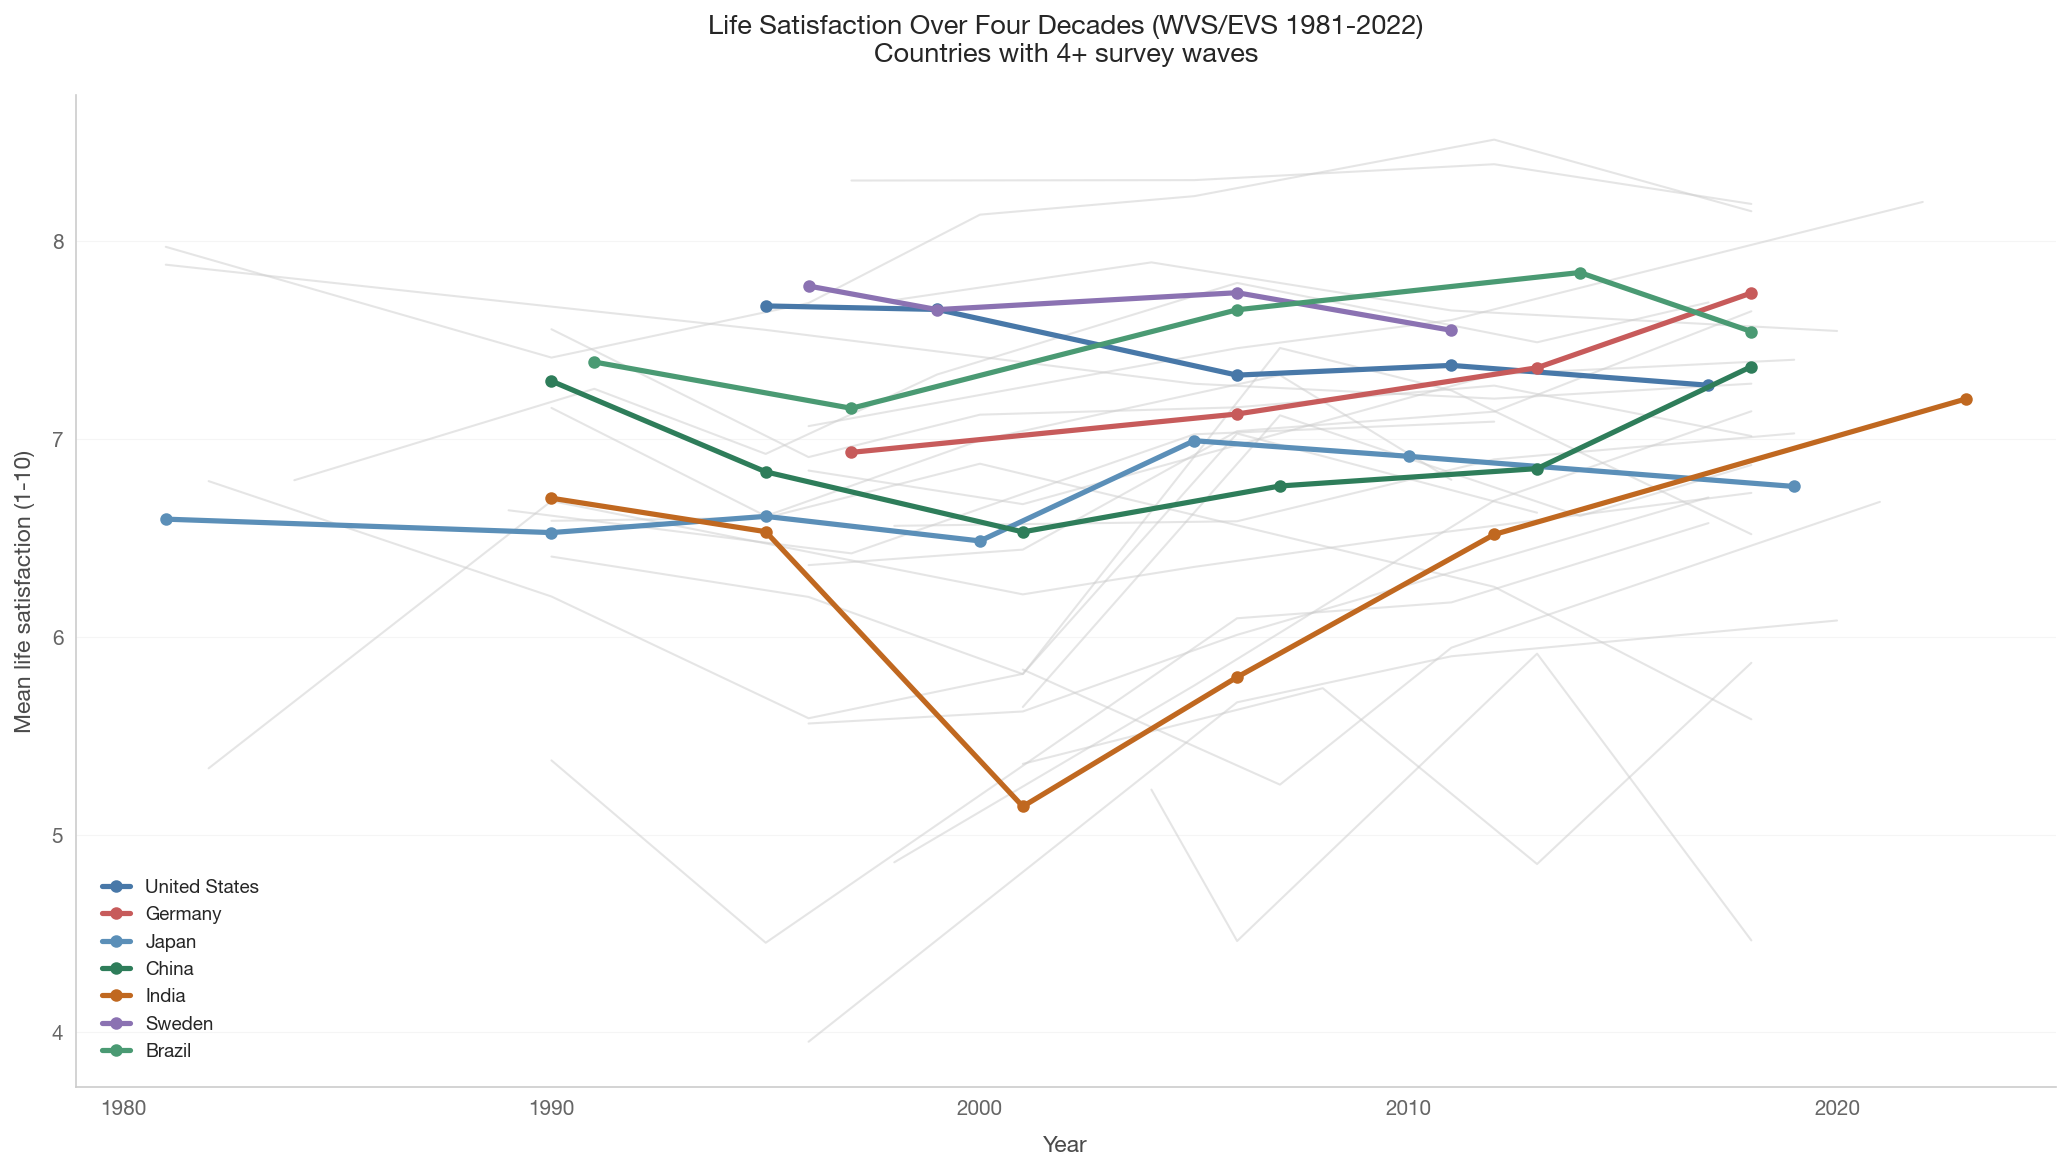

In [13]:
if wvs_available and not wvs_trend.empty:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Highlight key countries
    highlight = ['US', 'DE', 'JP', 'CN', 'IN', 'GB', 'SE', 'BR']
    highlight = [c for c in highlight
                 if c in wvs_trend['country_code'].unique()]

    # Background: all countries in gray
    for cc in wvs_trend['country_code'].unique():
        if cc not in highlight:
            cdf = wvs_trend[wvs_trend['country_code'] == cc].sort_values(
                'year_midpoint')
            ax.plot(cdf['year_midpoint'], cdf['mean_satisfaction'],
                    color='#cccccc', linewidth=1, alpha=0.5)

    # Foreground: highlighted countries
    for cc in highlight:
        cdf = wvs_trend[wvs_trend['country_code'] == cc].sort_values(
            'year_midpoint')
        if not cdf.empty:
            ax.plot(cdf['year_midpoint'], cdf['mean_satisfaction'],
                    color=country_color(cc), linewidth=2.5,
                    marker='o', markersize=5,
                    label=country_name(cc))

    ax.set_xlabel('Year')
    ax.set_ylabel('Mean life satisfaction (1-10)')
    ax.set_title('Life Satisfaction Over Four Decades (WVS/EVS 1981-2022)\n'
                 'Countries with 4+ survey waves',
                 fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '08_wvs_timeseries')
    plt.show()
else:
    if not wvs_available:
        print('WVS data not available. See download instructions above.')

WVS long-run: r = 0.066, p = 0.7632


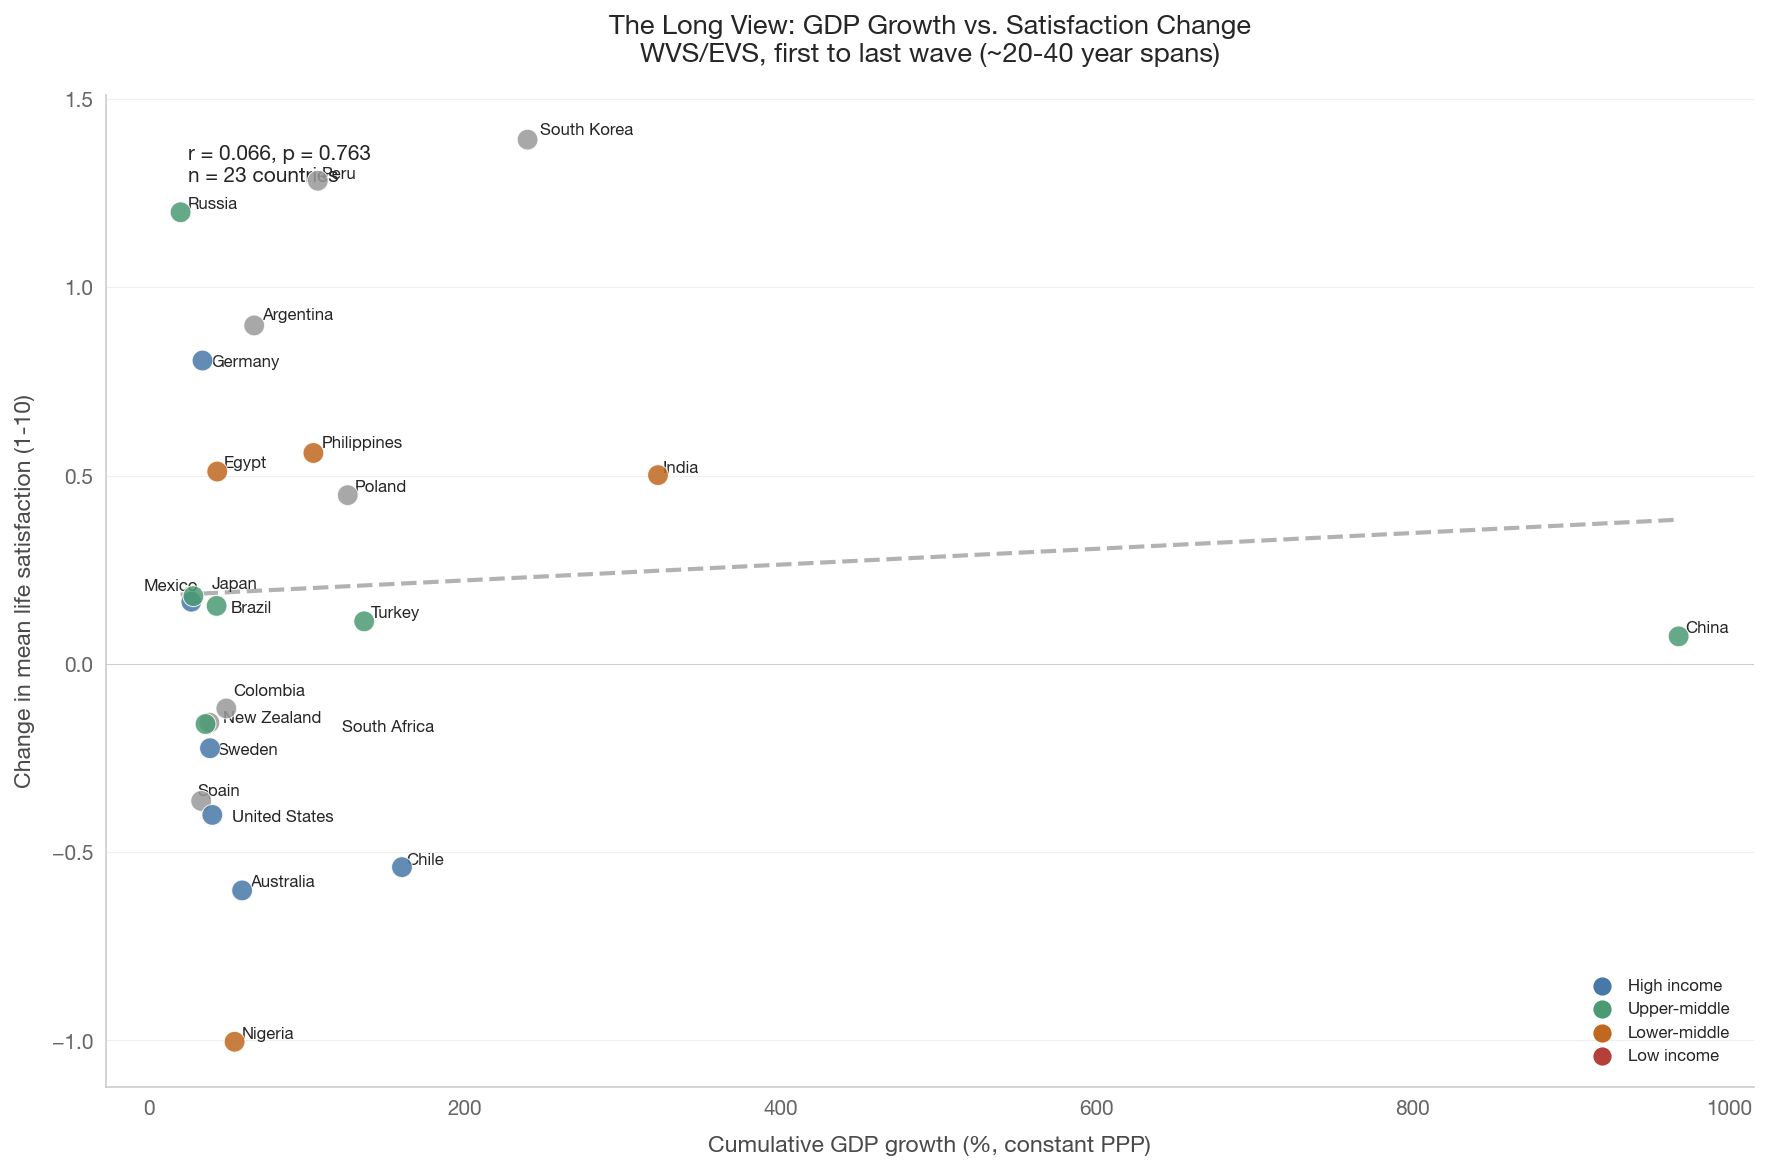

In [14]:
if wvs_available and not wvs_trend.empty:
    # For each WVS country, get first and last wave satisfaction
    # and corresponding GDP
    wvs_countries = wvs_trend['country_code'].unique().tolist()
    wvs_gdp = health_social.get_gdp_timeseries(
        countries=wvs_countries, start_year=1980, end_year=2023)

    wvs_deltas = []
    for cc, group in wvs_trend.groupby('country_code'):
        group = group.sort_values('year_midpoint')
        first_wave = group.iloc[0]
        last_wave = group.iloc[-1]

        # Find closest GDP year to each wave midpoint
        cc_gdp = wvs_gdp[wvs_gdp['country_code'] == cc]
        if cc_gdp.empty:
            continue

        gdp_first = cc_gdp.iloc[
            (cc_gdp['year'] - first_wave['year_midpoint']).abs().argsort()[:1]]
        gdp_last = cc_gdp.iloc[
            (cc_gdp['year'] - last_wave['year_midpoint']).abs().argsort()[:1]]

        if gdp_first.empty or gdp_last.empty:
            continue

        gdp_f = gdp_first['gdp_per_capita_ppp'].values[0]
        gdp_l = gdp_last['gdp_per_capita_ppp'].values[0]

        if gdp_f <= 0 or not np.isfinite(gdp_f):
            continue

        wvs_deltas.append({
            'country_code': cc,
            'year_start': int(first_wave['year_midpoint']),
            'year_end': int(last_wave['year_midpoint']),
            'delta_satisfaction': (last_wave['mean_satisfaction']
                                   - first_wave['mean_satisfaction']),
            'pct_gdp_growth': (gdp_l / gdp_f - 1) * 100,
            'delta_log_gdp': np.log(gdp_l) - np.log(gdp_f),
        })

    wvs_delta_df = pd.DataFrame(wvs_deltas)

    if len(wvs_delta_df) >= 5:
        fig, ax = plt.subplots(figsize=(12, 8))

        colors = [tier_color(c) for c in wvs_delta_df['country_code']]
        ax.scatter(wvs_delta_df['pct_gdp_growth'],
                   wvs_delta_df['delta_satisfaction'],
                   c=colors, s=100, zorder=5, edgecolors='white',
                   linewidth=0.5, alpha=0.85)

        x = wvs_delta_df['pct_gdp_growth'].values
        y = wvs_delta_df['delta_satisfaction'].values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 3:
            sl, it, r, p, _ = stats.linregress(x[mask], y[mask])
            xf = np.linspace(x[mask].min(), x[mask].max(), 100)
            ax.plot(xf, it + sl * xf, color='gray', linestyle='--',
                    linewidth=2, alpha=0.6)
            ax.text(0.05, 0.95,
                    f'r = {r:.3f}, p = {p:.3f}\n'
                    f'n = {mask.sum()} countries',
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='white',
                              alpha=0.8))
            print(f"WVS long-run: r = {r:.3f}, p = {p:.4f}")

        annotate_countries(
            ax, wvs_delta_df['pct_gdp_growth'].values,
            wvs_delta_df['delta_satisfaction'].values,
            wvs_delta_df['country_code'].values, fontsize=8)

        ax.axhline(0, color='gray', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Cumulative GDP growth (%, constant PPP)')
        ax.set_ylabel('Change in mean life satisfaction (1-10)')
        ax.set_title('The Long View: GDP Growth vs. Satisfaction Change\n'
                     'WVS/EVS, first to last wave (~20-40 year spans)',
                     fontsize=13)

        for tier, color in TIER_COLORS.items():
            ax.scatter([], [], c=color, s=60, label=tier)
        ax.legend(loc='lower right', fontsize=8)

        plt.tight_layout()
        save_figure(fig, '08_wvs_growth_vs_satisfaction')
        plt.show()
    else:
        print(f'Only {len(wvs_delta_df)} countries have WVS + GDP data. '
              f'Need at least 5.')
else:
    if not wvs_available:
        print('WVS data not available for growth-satisfaction analysis.')

***
## 7. The Ordinal Scale Problem

Bond & Lang (2025) raise a fundamental methodological challenge: the
GSS happiness question uses a 3-point ordinal scale (very happy, pretty
happy, not too happy). We can rank responses, but we don't know the
*cardinal distance* between categories.

If we assume equal spacing (1, 2, 3), the US trend is flat. But if we
assume "very happy" is much further from "pretty happy" than "pretty
happy" is from "not too happy," the same raw data could show a downward
trend — and vice versa.

This matters because the Easterlin Paradox is fundamentally about
whether the *level* of happiness has changed, which requires cardinal
assumptions about an ordinal scale.

Equal spacing (1, 2, 3): slope = -0.139/yr, p = 0.0001 (falling, significant)
Top-heavy (1, 2, 10): slope = -0.365/yr, p = 0.0000 (falling, significant)
Bottom-heavy (1, 2.8, 3): slope = -0.097/yr, p = 0.0009 (falling, significant)


/var/folders/fh/gvmnlwv90s90_gd0vgv823980000gn/T/ipykernel_48699/3125997970.py:56: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  plt.tight_layout()
/Users/clayborneo/Desktop/claude_code/research/income_inequality/notebooks/../data/plotting.py:186: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  fig.savefig(path, bbox_inches="tight", facecolor="white",


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  fig.canvas.print_figure(bytes_io, **kw)


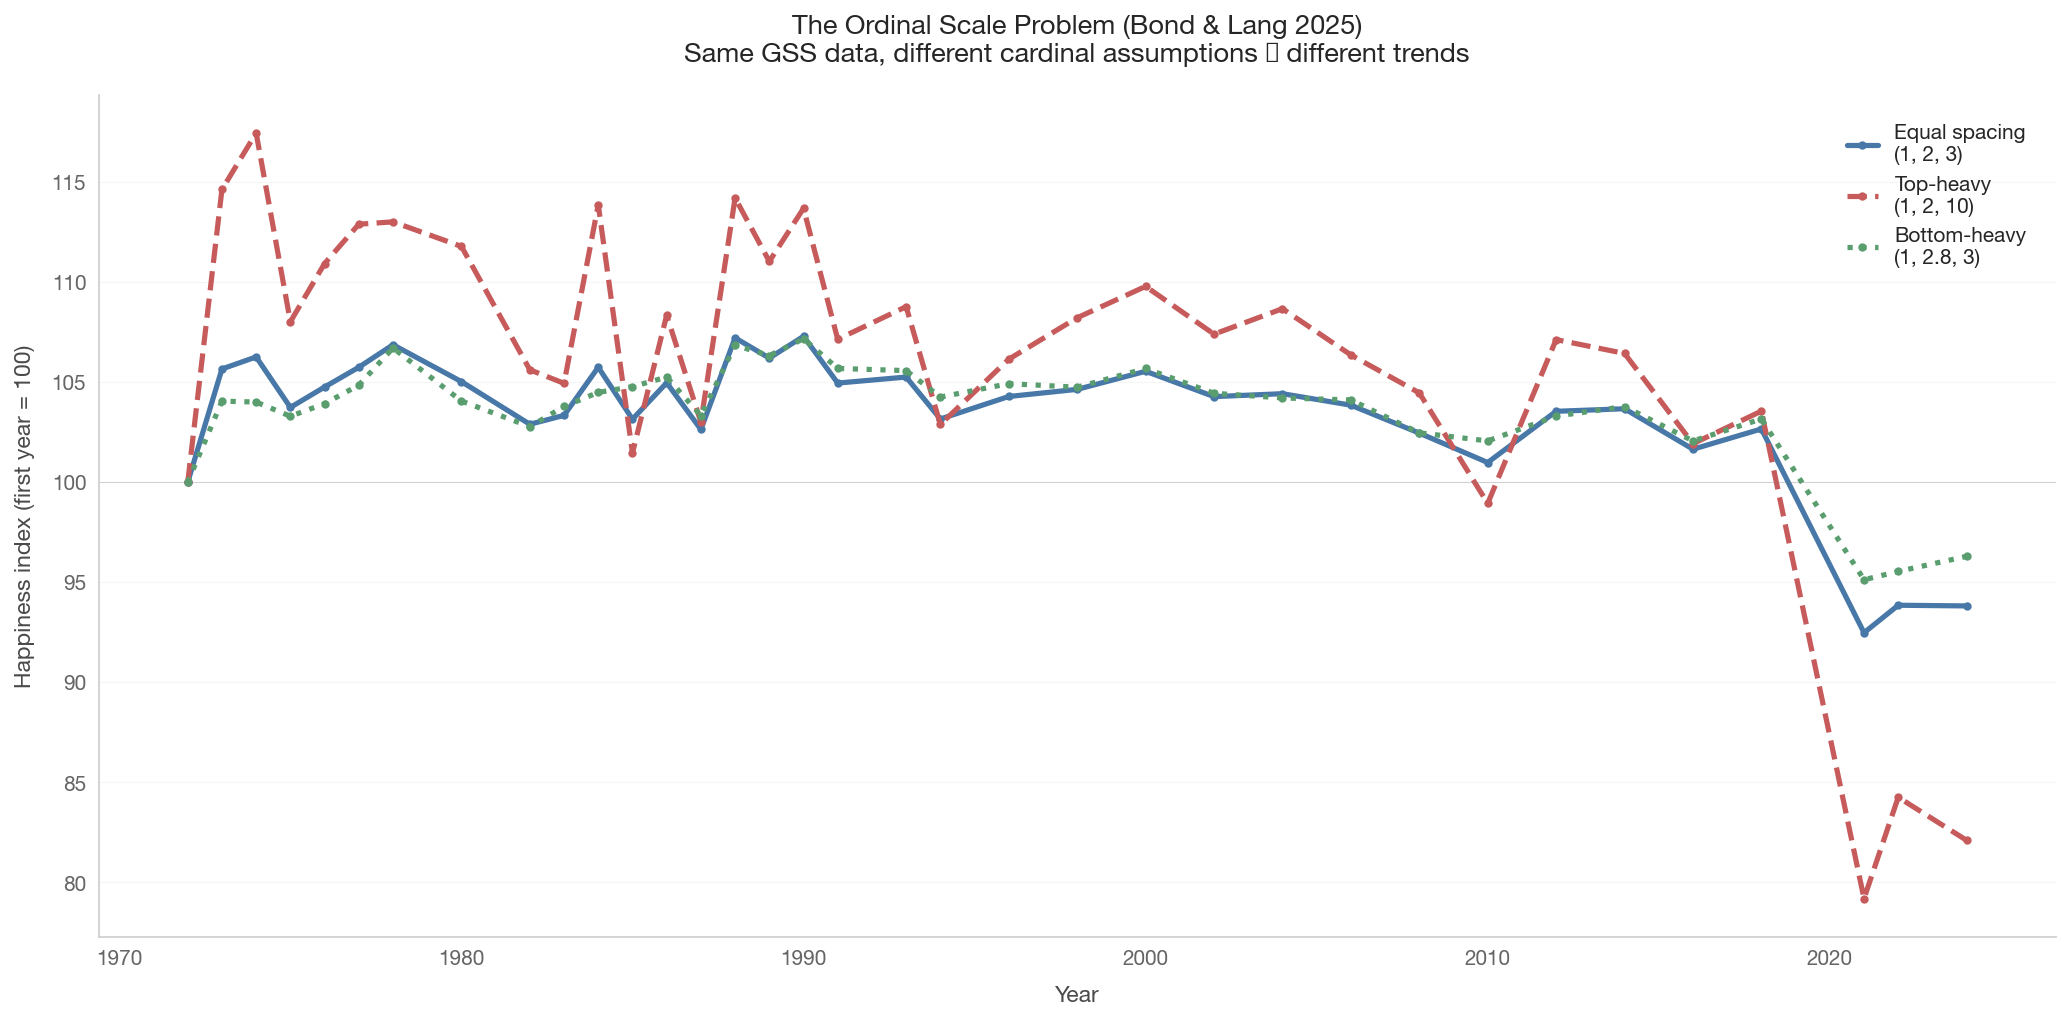

In [15]:
if gss_available:
    gss_raw = gss.load_gss()

    # Define three rescalings (higher = happier)
    # GSS codes: 1=very happy, 2=pretty happy, 3=not too happy
    rescalings = {
        'Equal spacing\n(1, 2, 3)': {1: 3, 2: 2, 3: 1},
        'Top-heavy\n(1, 2, 10)': {1: 10, 2: 2, 3: 1},
        'Bottom-heavy\n(1, 2.8, 3)': {1: 3, 2: 2.8, 3: 1},
    }

    fig, ax = plt.subplots(figsize=(14, 7))
    line_styles = ['-', '--', ':']
    line_colors = ['#4878a8', '#c75b5b', '#5a9e6f']

    for idx, (label, mapping) in enumerate(rescalings.items()):
        yearly = []
        for year, group in gss_raw.groupby('year'):
            w = group['weight'].values
            h_rescaled = group['happy'].map(mapping).values
            total_w = w.sum()
            if total_w > 0:
                mean_h = np.sum(w * h_rescaled) / total_w
                yearly.append({'year': year, 'mean_happy': mean_h})

        ydf = pd.DataFrame(yearly)
        if ydf.empty:
            continue

        # Normalize to start at 100 for comparability
        base = ydf['mean_happy'].iloc[0]
        ydf['index'] = ydf['mean_happy'] / base * 100

        ax.plot(ydf['year'], ydf['index'],
                color=line_colors[idx], linewidth=2.5,
                linestyle=line_styles[idx],
                label=label, marker='o', markersize=3)

        # Report trend
        sl, it, r, p, _ = stats.linregress(ydf['year'], ydf['index'])
        direction = 'rising' if sl > 0 else 'falling'
        sig = 'significant' if p < 0.05 else 'not significant'
        print(f"{label.replace(chr(10), ' ')}: slope = {sl:+.3f}/yr, "
              f"p = {p:.4f} ({direction}, {sig})")

    ax.axhline(100, color='gray', alpha=0.3, linewidth=0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Happiness index (first year = 100)')
    ax.set_title('The Ordinal Scale Problem (Bond & Lang 2025)\n'
                 'Same GSS data, different cardinal assumptions \u2192 '
                 'different trends',
                 fontsize=13)
    ax.legend(loc='best', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    save_figure(fig, '08_ordinal_sensitivity')
    plt.show()
else:
    print('GSS data not available for ordinal sensitivity analysis.')

***
## 8. Key Takeaways

### The paradox is real — or at least, not easily dismissed

The cross-sectional evidence from Notebook 07 predicted that countries
doubling their GDP should see a meaningful rise in average happiness.
The time-series evidence presented here does not clearly confirm that
prediction:

- **The US case** (GSS, 1972–present): Real GDP roughly tripled.
  Happiness was flat to declining. This is the strongest single-country
  evidence for the paradox.

- **The global panel** (Gallup, 2005–2024): Mixed. Some countries show
  rising happiness, others falling, with no clear pattern linking growth
  rates to happiness changes.

- **Short-run vs. long-run**: Short-run GDP fluctuations do correlate
  with happiness changes (recessions hurt). But the long-run relationship
  is weaker or absent — consistent with the Easterlin & O'Connor (2020)
  interpretation.

### Why the tension between cross-section and time series?

Several mechanisms could explain why income predicts happiness *across*
countries at a moment in time, but not *within* countries over time:

1. **Social comparison**: Within a country at a given time, your income
   relative to others matters. When *everyone's* income rises together,
   relative positions don't change. Cross-nationally, richer countries
   really do have more material comfort than poorer ones.

2. **Hedonic adaptation**: People adapt to higher income. A raise feels
   good for a while, then becomes the new normal. The cross-section
   captures the permanent gap between rich and poor countries; the time
   series captures the transient effect of growth.

3. **Rising aspirations**: As income rises, so do expectations. What
   counted as "very happy" in 1972 may require more in 2024. Bond &
   Lang (2025) argue this could mask real happiness gains in ordinal
   survey responses.

4. **Non-income factors**: Growth may coincide with increased inequality,
   longer work hours, eroded social capital, or environmental degradation
   that offset the income gains. The cross-section compares countries at
   their current equilibrium; the time series tracks a country through
   disruptive change.

### What this means for the absolute-vs-relative debate

Notebook 07 concluded that absolute income dominates in the cross-section.
This notebook suggests the picture is more nuanced:

- **Across countries**: Absolute income is the dominant predictor. Being
  a rich country is genuinely better than being a poor one.
- **Over time within countries**: Absolute income gains do not reliably
  translate to happiness gains. Relative position and adaptation may
  dominate.

The Easterlin Paradox, nearly 50 years after its formulation, remains
one of the most provocative findings in economics. The data cannot
fully resolve it — in part because ordinal happiness scales may not be
sensitive enough to detect the changes we're looking for (Bond & Lang
2025). What the data *do* tell us is that economic growth alone is not
a sufficient recipe for national well-being.

### Data limitations

- The GSS uses a 3-point scale with limited sensitivity to changes.
  The ordinal-to-cardinal mapping is fundamentally underdetermined.
- The Gallup World Poll only spans ~19 years — arguably too short for
  a definitive test of long-run trends.
- The WVS surveys countries in waves, not annually, creating gaps
  and making precise trend estimation difficult.
- All three sources measure *self-reported* subjective well-being,
  which may not capture all dimensions of human flourishing.
- Cross-country comparisons of subjective scales face potential
  cultural response bias ("satisficing" norms differ across cultures).